In [1]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}

In [1]:
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import ephem
import datetime
import numpy as np
import seaborn as sns
from scipy import signal
from IPython import display
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, DivergingNorm, SymLogNorm

sns.set()
sns.set_style("ticks")

In [3]:
from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.common_vars.directories import LUIGI_OUT_FOLDER,POSTPROCESS_OUT_FOLDER
from spectral_analysis.common_vars.regions import ids_regions,lats4id,lons4id,faces_regions
from spectral_analysis.isotropic_spectra.spectral_kinema import spectral_kinematics
from spectral_analysis.isotropic_spectra.co_spec import cospec_ab
from spectral_analysis.isotropic_spectra.isotropic import calc_ispec
from spectral_analysis.luigi_workflows.output import theta4idt,Theta4id,uv4idt,UV4id,tau4idt,Tau4id,VorticityGrid,H4id
from spectral_analysis.luigi_workflows.llc_region import LLCRegion

In [4]:
cmap_ranges = {
    "KE": [-1e-2,1e-2],
    "RV": [1e-12,1e-10],
    "DIV": [1e-12,1e-10],
    "RVDIV": [0.1,10]
}

In [5]:
xlims = [1/150,1/8]
xticks = [1/10,1/25,1/50,1/80,1/150]
xticksLabel = ['10','25','50','80','150']
yticks = [1/3,1/6,1/12,1/24,1/(24*7),1/(24*30)]
yticksLabel = ['3 h','6 h','12 h','1 d','1 w','1 mo']
# Lt plots
xticks_ = [1/10,1/20,1/30,1/40,1/50,1/75,1/100,1/150]
xticksLabel_ = ['10','20','30','40','50','75','100','150']

In [6]:
def plot_cospectra(ki, omega, S, title, linthresh=1e-8, cmap='bwr', vminmax=None):
    #plt.figure(figsize=(8,6))
    SS = (omega*S).T*ki
    if vminmax is None:
        vminmax = max(abs(np.min(SS)), np.max(SS))
    plt.pcolormesh(ki, omega, SS, norm = SymLogNorm(linthresh=linthresh,vmin=-1*vminmax,vmax=vminmax), cmap=cmap)
    #plt.clim(cmap_ranges["KE"])
    plt.xscale('log')
    plt.xticks(xticks,xticksLabel)
    plt.xlim(xlims)
    plt.yscale('log')
    plt.ylim([omega[1],omega[-100]])
    plt.yticks(yticks,yticksLabel)
    plt.colorbar()
    plt.xlabel('Horizontal scales [km]')
    plt.ylabel('Time scales')
    plt.title(title)
    #plt.show()

In [7]:
def plotRegion(regionId, season):
    timevec = idx_t["hours"][season]
    # Load vars
    region = LLCRegion(regionId, timevec)
    region.loadScalar("oceQnet")
    region.loadHorizontalVector("U", "V", "uv")
    region.loadHorizontalVector("oceTAUX", "oceTAUY", "tau")
    region.norm("tau", "tau_norm")
    region.hcurl("tau", "tau_curl")
    region.hcurl("uv", "uv_curl")
    region.divergence("uv", "uv_div")

    # Get vars
    qFlux = region.get("oceQnet");
    DIV = region.get("uv_div")
    RV = region.get("uv_curl")
    tau = region.get("tau_norm")
    rotTau = region.get("tau_curl")

    ## Cospectra oceQnet - RV/DIV
    co_qfluxRV,kx,ky,omega,dkx,dky,domega = cospec_ab(qFlux,RV,2,2,1)
    ki,co_qfluxRV_iso = calc_ispec(co_qfluxRV,kx,ky,omega)
    co_qfluxRV_iso.shape
    co_qfluxDIV,kx,ky,omega,dkx,dky,domega = cospec_ab(qFlux,DIV,2,2,1)
    ki,co_qfluxDIV_iso = calc_ispec(co_qfluxDIV,kx,ky,omega)
    co_qfluxDIV_iso.shape

    ## Cospectra tau - RV/DIV
    cospec_rvTau,kx,ky,omega,dkx,dky,domega = cospec_ab(RV,tau,2,2,1)
    ki,cospec_rv_iso = calc_ispec(cospec_rvTau,kx,ky,omega)
    cospec_rv_iso.shape
    cospec_divTau,kx,ky,omega,dkx,dky,domega = cospec_ab(DIV,tau,2,2,1)
    ki,cospec_div_iso = calc_ispec(cospec_divTau,kx,ky,omega)
    cospec_div_iso.shape

    ## Cospectra rot(tau) - RV/DIV
    cospec_rvRottau,kx,ky,omega,dkx,dky,domega = cospec_ab(RV,rotTau,2,2,1)
    ki,cospec_rvRottau_iso = calc_ispec(cospec_rvRottau,kx,ky,omega)
    cospec_rvRottau_iso.shape
    cospec_divRottau,kx,ky,omega,dkx,dky,domega = cospec_ab(DIV,rotTau,2,2,1)
    ki,cospec_divrotTau_iso = calc_ispec(cospec_divRottau,kx,ky,omega)
    cospec_divrotTau_iso.shape

    # Plot
    fig, ax = plt.subplots(3,2,figsize=(16,20))
    ax = ax.flat[:]

    ## Cospectra oceQnet - RV/DIV
    plt.sca(ax[0])
    plot_cospectra(ki, omega, co_qfluxRV_iso, "oceQnet - RV - {} ({})".format(regionId, season), 1e-7)
    plt.sca(ax[1])
    plot_cospectra(ki, omega, co_qfluxDIV_iso, "oceQnet - DIV - {} ({})".format(regionId, season), 1e-7)

    ## Cospectra tau - RV/DIV
    plt.sca(ax[2])
    plot_cospectra(ki, omega, cospec_rv_iso, "RV - |Tau| - {} ({})".format(regionId, season), 1e-10)
    plt.sca(ax[3])
    plot_cospectra(ki, omega, cospec_div_iso, "DIV - |Tau| - {} ({})".format(regionId, season), 1e-10)

    ## Cospectra rot(tau) - RV/DIV
    plt.sca(ax[4])
    plot_cospectra(ki, omega, cospec_rvRottau_iso, "RV - rot(Tau) - {} ({})".format(regionId, season), 5e-14)
    plt.sca(ax[5])
    plot_cospectra(ki, omega, cospec_divrotTau_iso, "DIV - rot(Tau) - {} ({})".format(regionId, season), 5e-14)
    plt.show()

In [8]:
def calc_cospectra(current):
    for rid in ids_regions[current]:
        for season in ["ASO","JFM"]:
            print("Plotting {}: {} {}".format(current,rid,season))
            try:
                plotRegion(rid, season)
            except Exception as err:
                print(err)

Plotting California: 868 ASO
2020-11-20 12:24:14 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)
2020-11-20 12:27:07 INFO     Loading U: shape (k=0): (290, 289, 2208)
2020-11-20 12:29:52 INFO     Loading V: shape (k=0): (290, 289, 2208)
2020-11-20 12:32:37 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2020-11-20 12:35:12 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)
2020-11-20 12:37:50 INFO     Calculating tau_norm = |tau|
2020-11-20 12:37:51 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 12:37:57 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 12:38:01 INFO     Calculating uv_div = div(uv)
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208


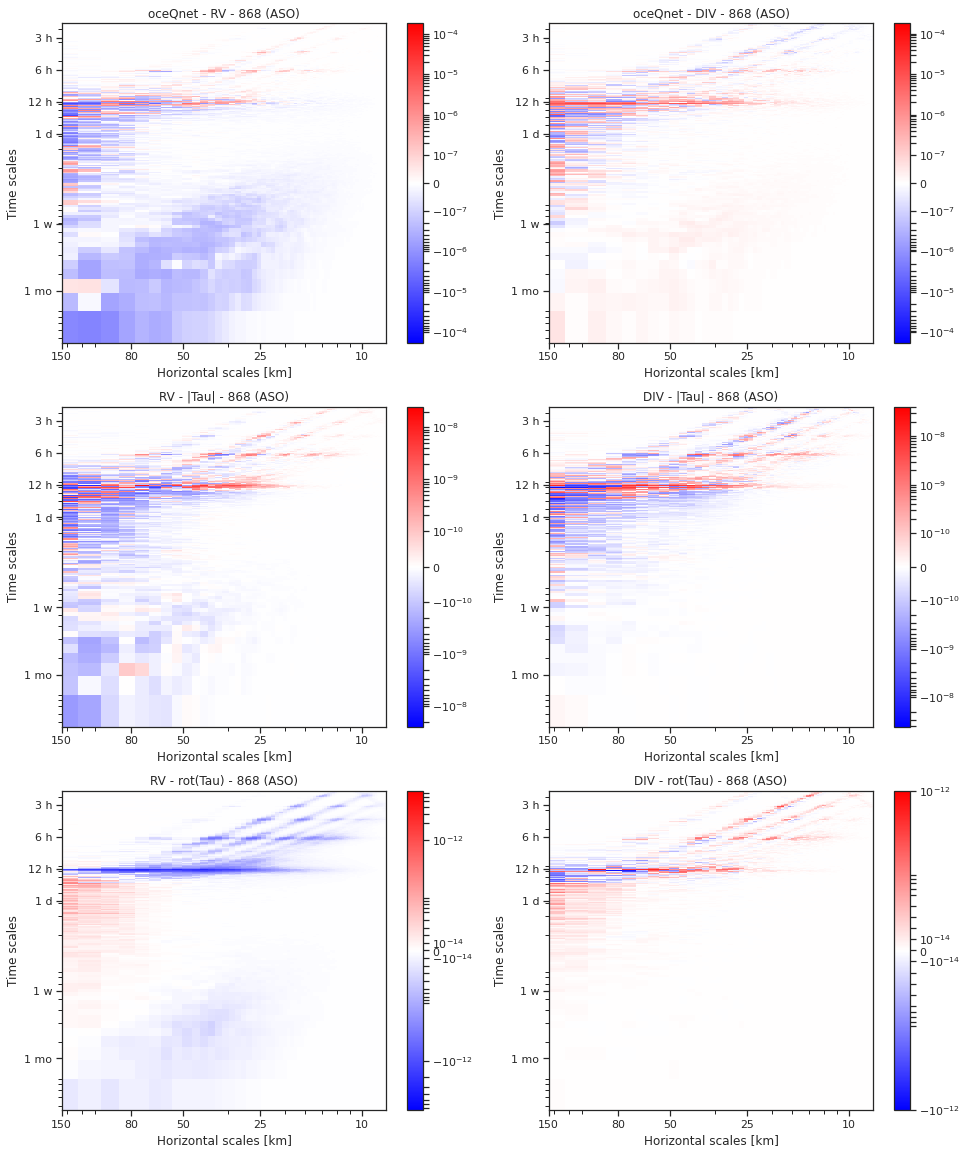

Plotting California: 868 JFM
2020-11-20 12:41:06 INFO     Loading oceQnet: shape (k=0): (290, 289, 2184)
2020-11-20 12:43:11 INFO     Loading U: shape (k=0): (290, 289, 2184)
2020-11-20 12:45:31 INFO     Loading V: shape (k=0): (290, 289, 2184)
2020-11-20 12:47:54 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2184)
2020-11-20 12:49:59 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2184)
2020-11-20 12:52:02 INFO     Calculating tau_norm = |tau|
2020-11-20 12:52:03 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 12:52:08 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 12:52:13 INFO     Calculating uv_div = div(uv)
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184


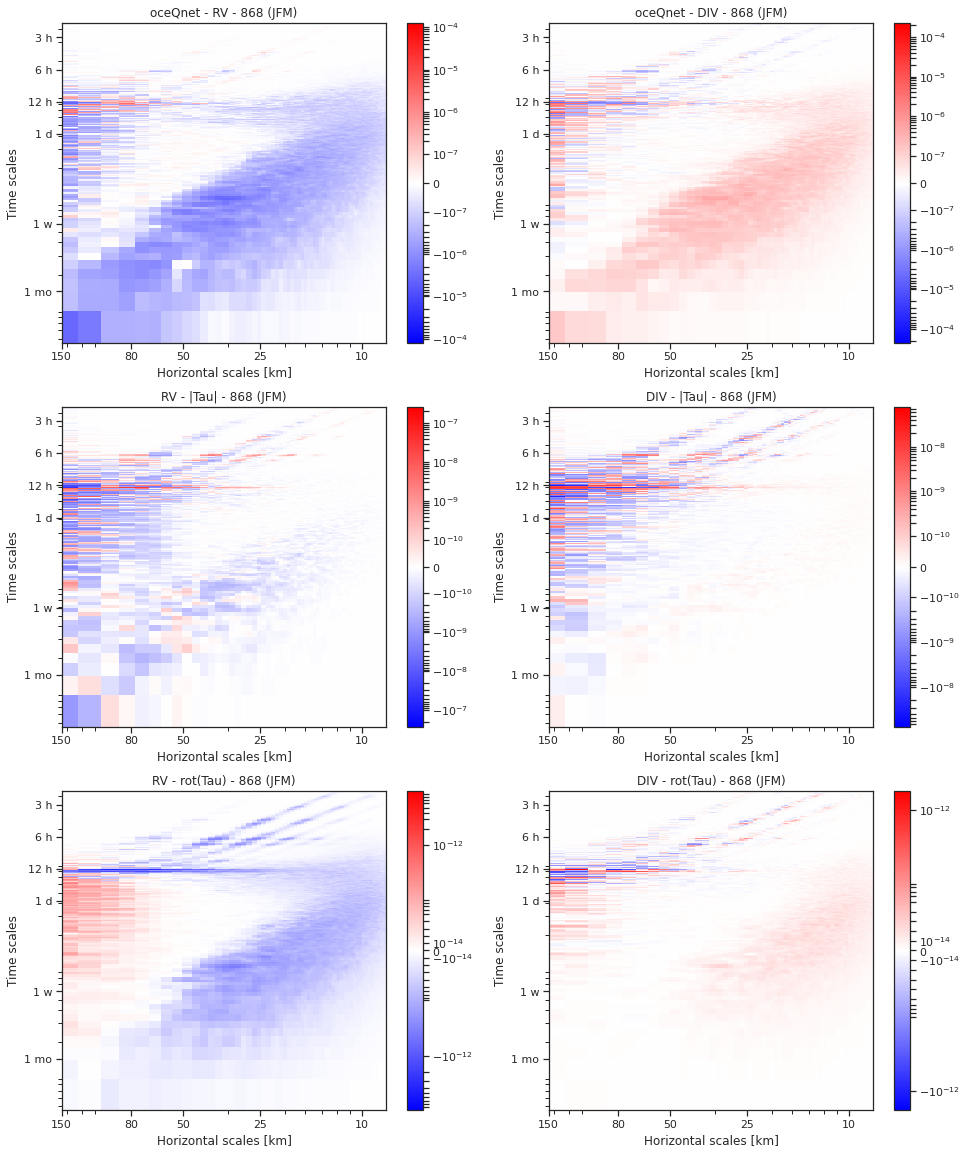

Plotting California: 852 ASO
/mnt/disks/LLC4320/Luigi/Datasets_compressed/852/hours/lon_c.txt not found.
Plotting California: 852 JFM
/mnt/disks/LLC4320/Luigi/Datasets_compressed/852/hours/lon_c.txt not found.
Plotting California: 831 ASO
/mnt/disks/LLC4320/Luigi/Datasets_compressed/831/hours/lon_c.txt not found.
Plotting California: 831 JFM
/mnt/disks/LLC4320/Luigi/Datasets_compressed/831/hours/lon_c.txt not found.
Plotting California: 809 ASO
/mnt/disks/LLC4320/Luigi/Datasets_compressed/809/hours/lon_c.txt not found.
Plotting California: 809 JFM
/mnt/disks/LLC4320/Luigi/Datasets_compressed/809/hours/lon_c.txt not found.
Plotting California: 787 ASO
2020-11-20 12:55:15 INFO     Loading oceQnet: shape (k=0): (291, 289, 2208)
2020-11-20 12:56:34 INFO     Loading U: shape (k=0): (291, 289, 2208)
2020-11-20 12:57:53 INFO     Loading V: shape (k=0): (291, 289, 2208)
2020-11-20 12:58:09 INFO     Loading oceTAUX: shape (k=0): (291, 289, 2208)
2020-11-20 12:58:23 INFO     Loading oceTAUY: sha

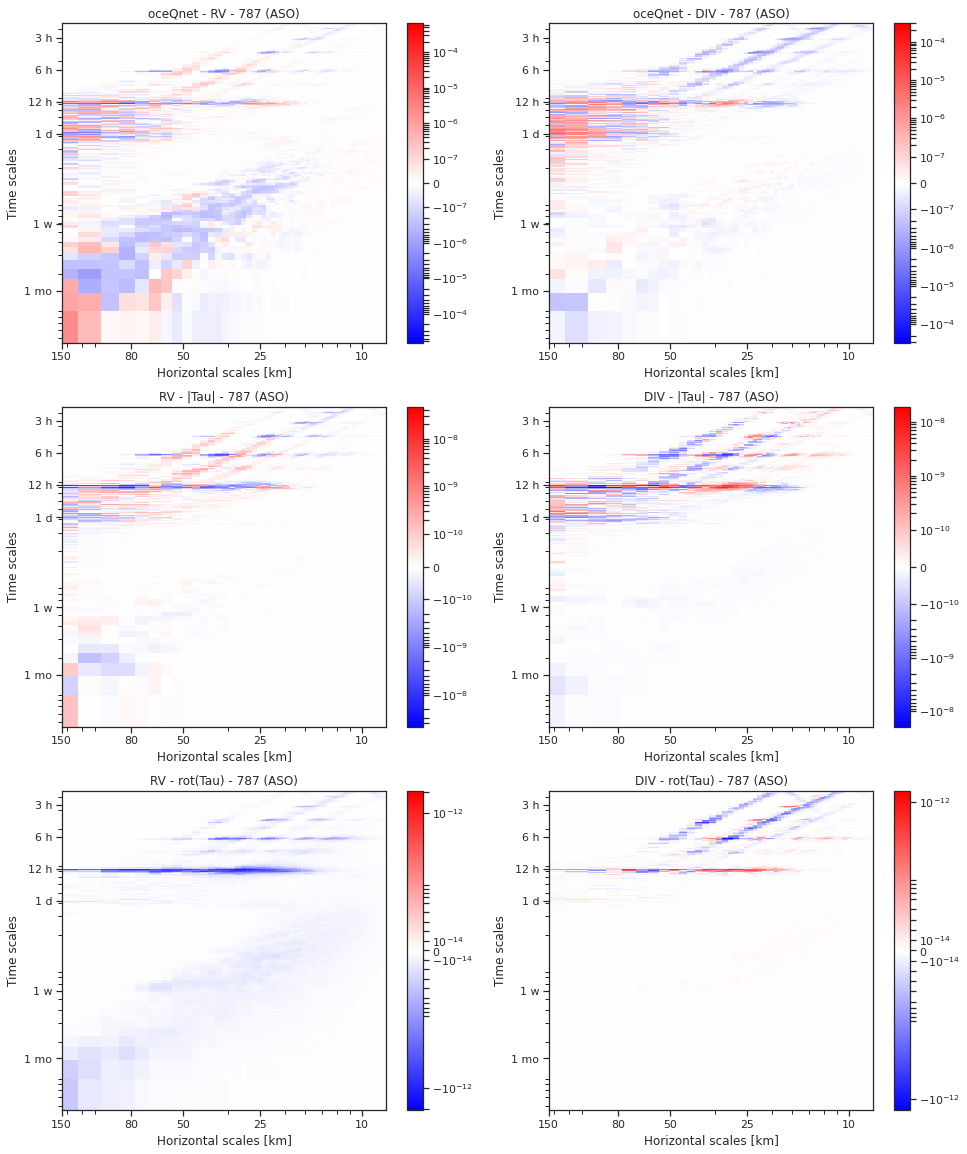

Plotting California: 787 JFM
2020-11-20 13:01:54 INFO     Loading oceQnet: shape (k=0): (291, 289, 2184)
2020-11-20 13:03:22 INFO     Loading U: shape (k=0): (291, 289, 2184)
2020-11-20 13:04:22 INFO     Loading V: shape (k=0): (291, 289, 2184)
2020-11-20 13:04:36 INFO     Loading oceTAUX: shape (k=0): (291, 289, 2184)
2020-11-20 13:04:50 INFO     Loading oceTAUY: shape (k=0): (291, 289, 2184)
2020-11-20 13:05:03 INFO     Calculating tau_norm = |tau|
2020-11-20 13:05:04 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 13:05:07 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 13:05:10 INFO     Calculating uv_div = div(uv)
before fftn
291 289 2184
before fftn
291 289 2184
before fftn
291 289 2184
before fftn
291 289 2184
before fftn
291 289 2184
before fftn
291 289 2184


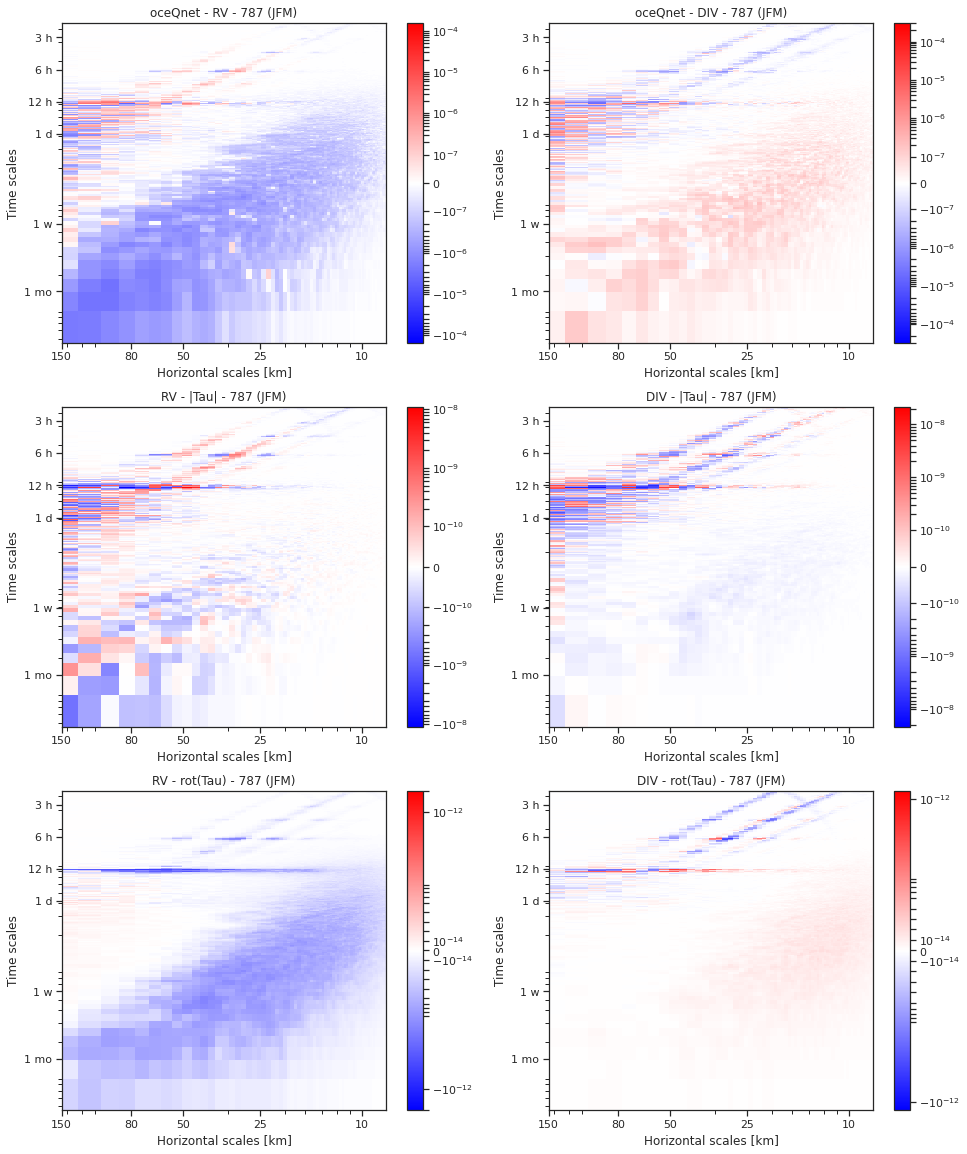

Plotting California: 762 ASO
2020-11-20 13:08:20 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2020-11-20 13:09:59 INFO     Loading U: shape (k=0): (288, 289, 2208)
2020-11-20 13:10:12 INFO     Loading V: shape (k=0): (288, 289, 2208)
2020-11-20 13:10:26 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2020-11-20 13:10:40 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)
2020-11-20 13:11:45 INFO     Calculating tau_norm = |tau|
2020-11-20 13:11:47 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 13:11:52 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 13:11:56 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208


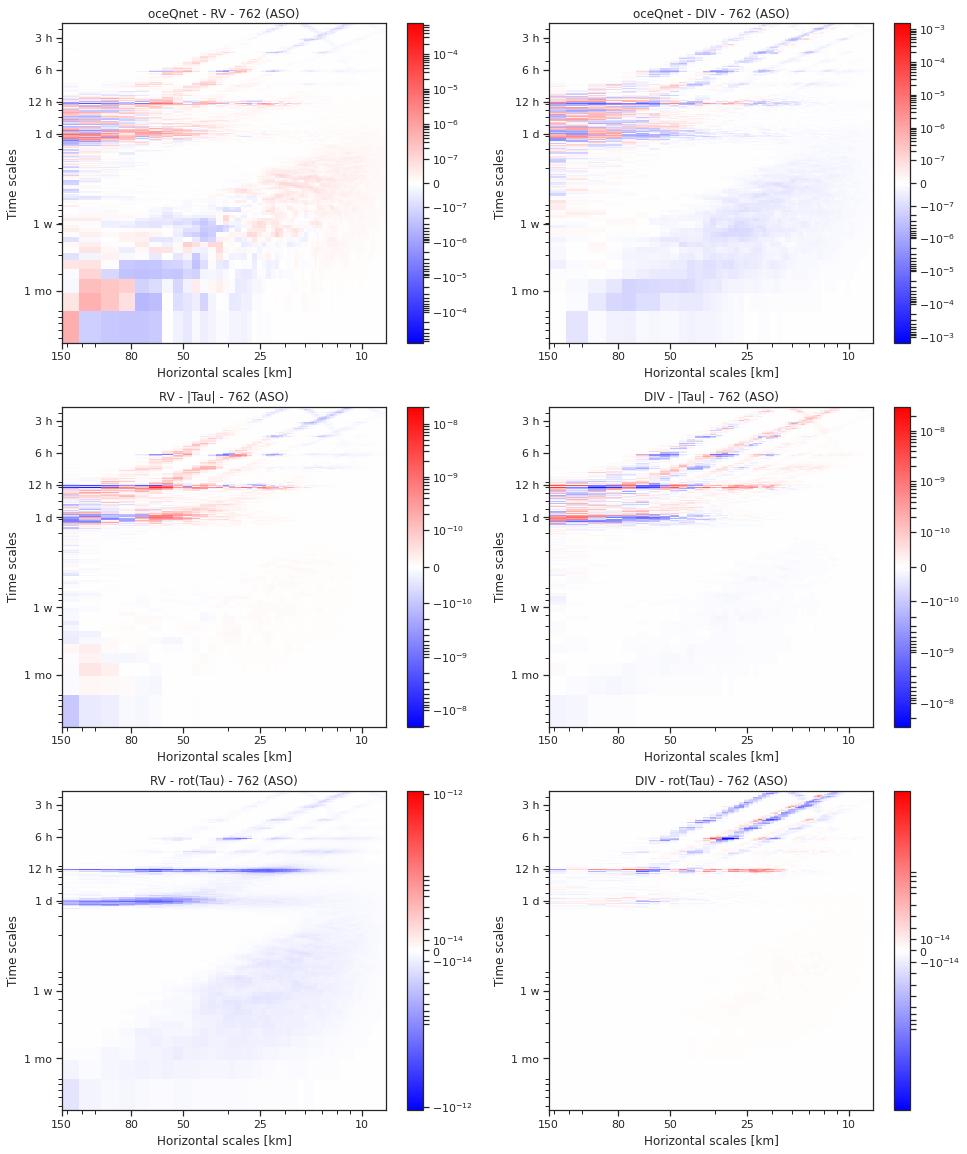

Plotting California: 762 JFM
2020-11-20 13:14:41 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)
2020-11-20 13:16:54 INFO     Loading U: shape (k=0): (288, 289, 2184)
2020-11-20 13:19:23 INFO     Loading V: shape (k=0): (288, 289, 2184)
2020-11-20 13:21:42 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2020-11-20 13:23:53 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)
2020-11-20 13:26:02 INFO     Calculating tau_norm = |tau|
2020-11-20 13:26:03 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 13:26:09 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 13:26:14 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184


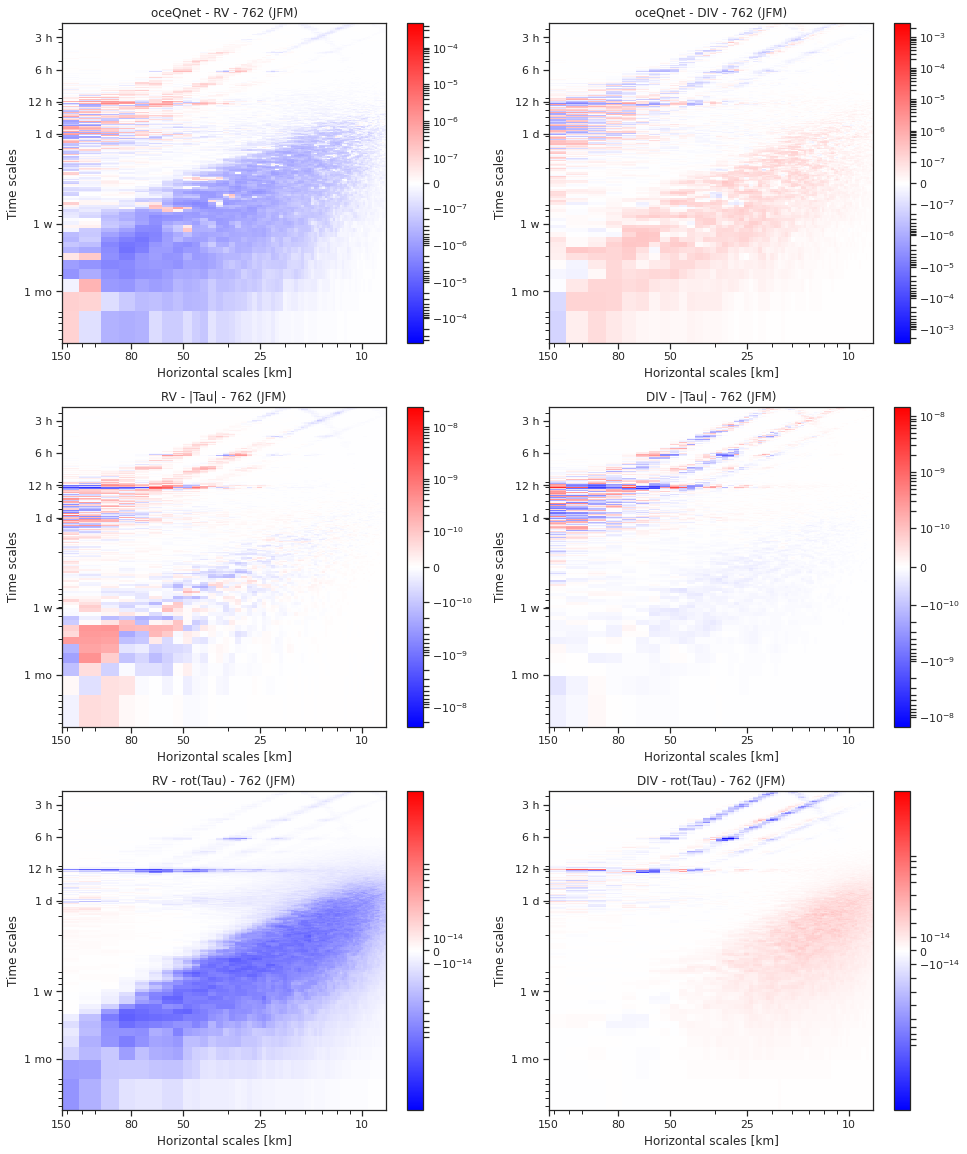

In [28]:
calc_cospectra("California")

Plotting Canarias: 771 ASO
2020-11-20 13:29:06 INFO     Loading oceQnet: shape (k=0): (291, 289, 2208)
2020-11-20 13:31:56 INFO     Loading U: shape (k=0): (291, 289, 2208)
2020-11-20 13:34:49 INFO     Loading V: shape (k=0): (291, 289, 2208)
2020-11-20 13:37:34 INFO     Loading oceTAUX: shape (k=0): (291, 289, 2208)
2020-11-20 13:40:11 INFO     Loading oceTAUY: shape (k=0): (291, 289, 2208)
2020-11-20 13:42:44 INFO     Calculating tau_norm = |tau|
2020-11-20 13:42:46 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 13:42:52 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 13:42:56 INFO     Calculating uv_div = div(uv)
before fftn
291 289 2208
before fftn
291 289 2208
before fftn
291 289 2208
before fftn
291 289 2208
before fftn
291 289 2208
before fftn
291 289 2208


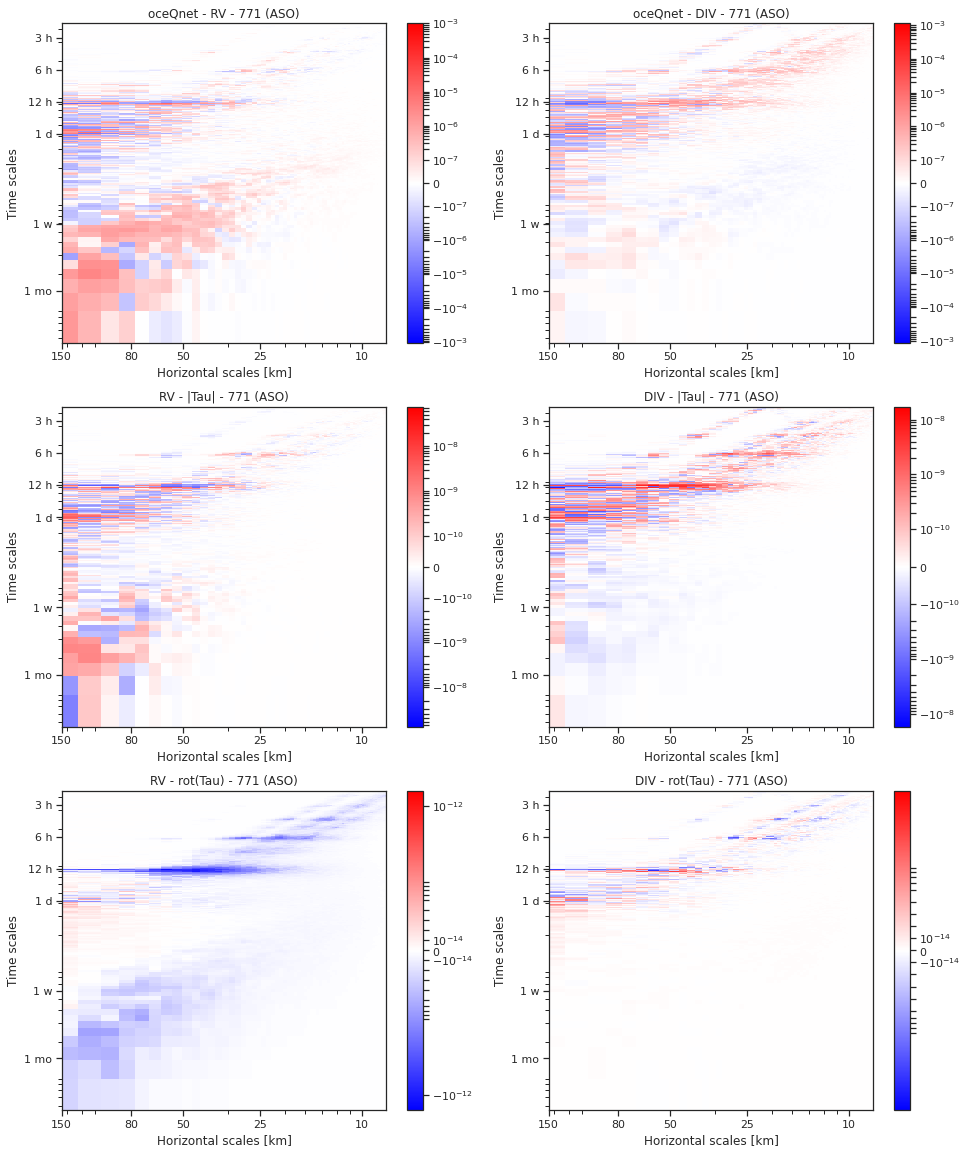

Plotting Canarias: 771 JFM
2020-11-20 13:46:01 INFO     Loading oceQnet: shape (k=0): (291, 289, 2184)
2020-11-20 13:47:57 INFO     Loading U: shape (k=0): (291, 289, 2184)
2020-11-20 13:50:06 INFO     Loading V: shape (k=0): (291, 289, 2184)
2020-11-20 13:52:16 INFO     Loading oceTAUX: shape (k=0): (291, 289, 2184)
2020-11-20 13:54:19 INFO     Loading oceTAUY: shape (k=0): (291, 289, 2184)
2020-11-20 13:56:17 INFO     Calculating tau_norm = |tau|
2020-11-20 13:56:19 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 13:56:25 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 13:56:30 INFO     Calculating uv_div = div(uv)
before fftn
291 289 2184
before fftn
291 289 2184
before fftn
291 289 2184
before fftn
291 289 2184
before fftn
291 289 2184
before fftn
291 289 2184


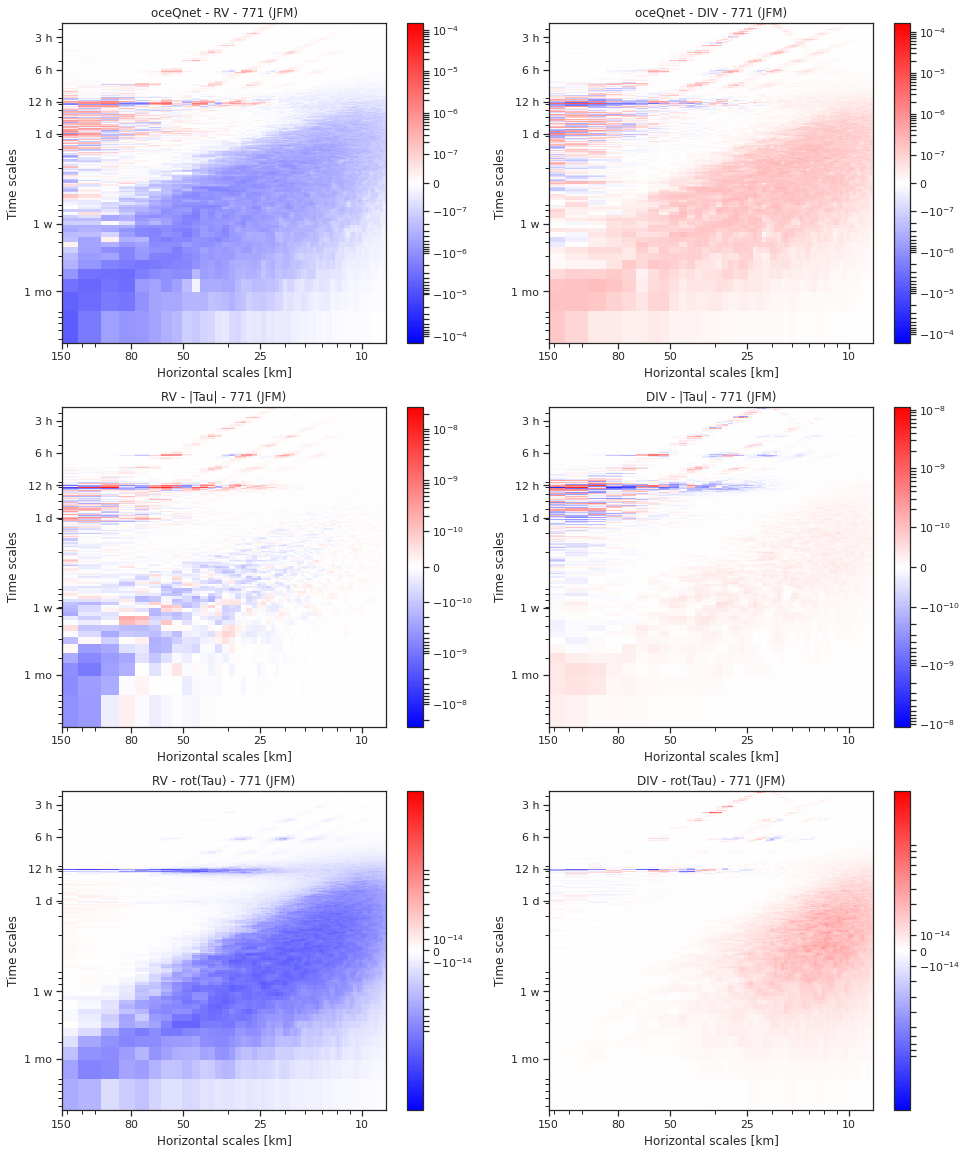

Plotting Canarias: 750 ASO
2020-11-20 13:59:37 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2020-11-20 14:02:30 INFO     Loading U: shape (k=0): (288, 289, 2208)
2020-11-20 14:05:17 INFO     Loading V: shape (k=0): (288, 289, 2208)
2020-11-20 14:08:03 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2020-11-20 14:10:54 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)
2020-11-20 14:13:48 INFO     Calculating tau_norm = |tau|
2020-11-20 14:13:50 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 14:13:56 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 14:14:00 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208


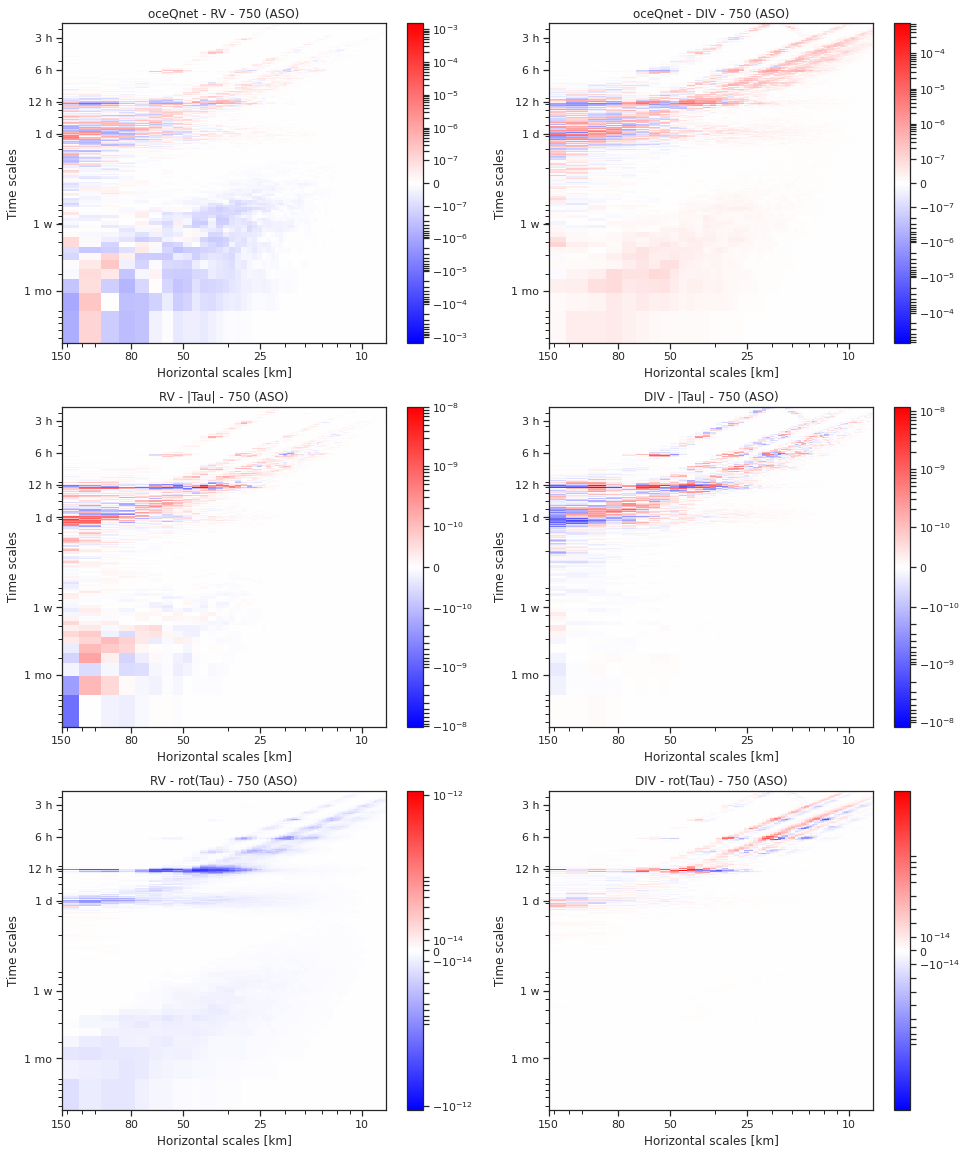

Plotting Canarias: 750 JFM
2020-11-20 14:16:59 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)
2020-11-20 14:19:12 INFO     Loading U: shape (k=0): (288, 289, 2184)
2020-11-20 14:21:34 INFO     Loading V: shape (k=0): (288, 289, 2184)
2020-11-20 14:23:56 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2020-11-20 14:26:04 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)
2020-11-20 14:28:04 INFO     Calculating tau_norm = |tau|
2020-11-20 14:28:05 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 14:28:11 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 14:28:15 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184


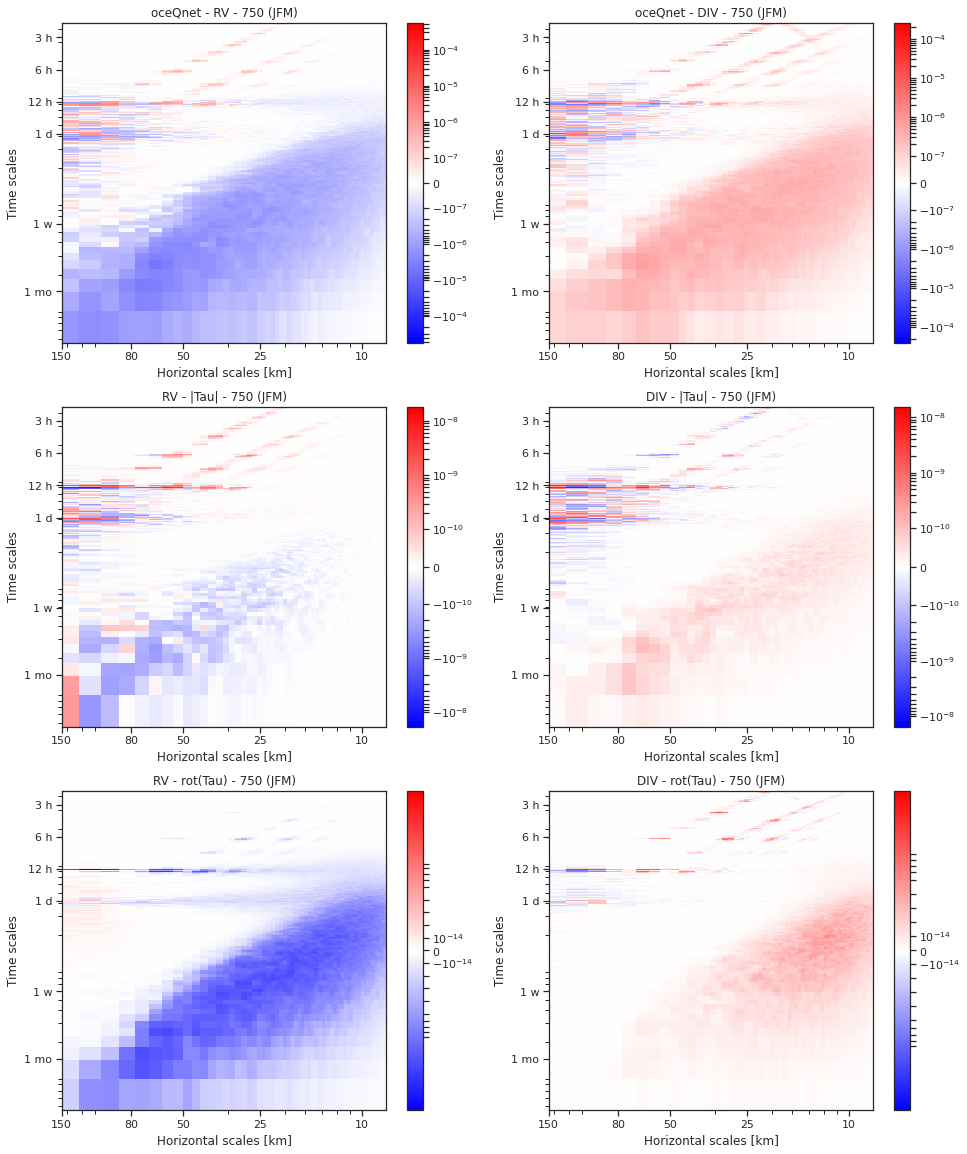

Plotting Canarias: 730 ASO
2020-11-20 14:31:04 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)
2020-11-20 14:33:57 INFO     Loading U: shape (k=0): (290, 289, 2208)
2020-11-20 14:36:40 INFO     Loading V: shape (k=0): (290, 289, 2208)
2020-11-20 14:39:20 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2020-11-20 14:41:57 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)
2020-11-20 14:44:31 INFO     Calculating tau_norm = |tau|
2020-11-20 14:44:34 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 14:44:40 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 14:44:44 INFO     Calculating uv_div = div(uv)
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208


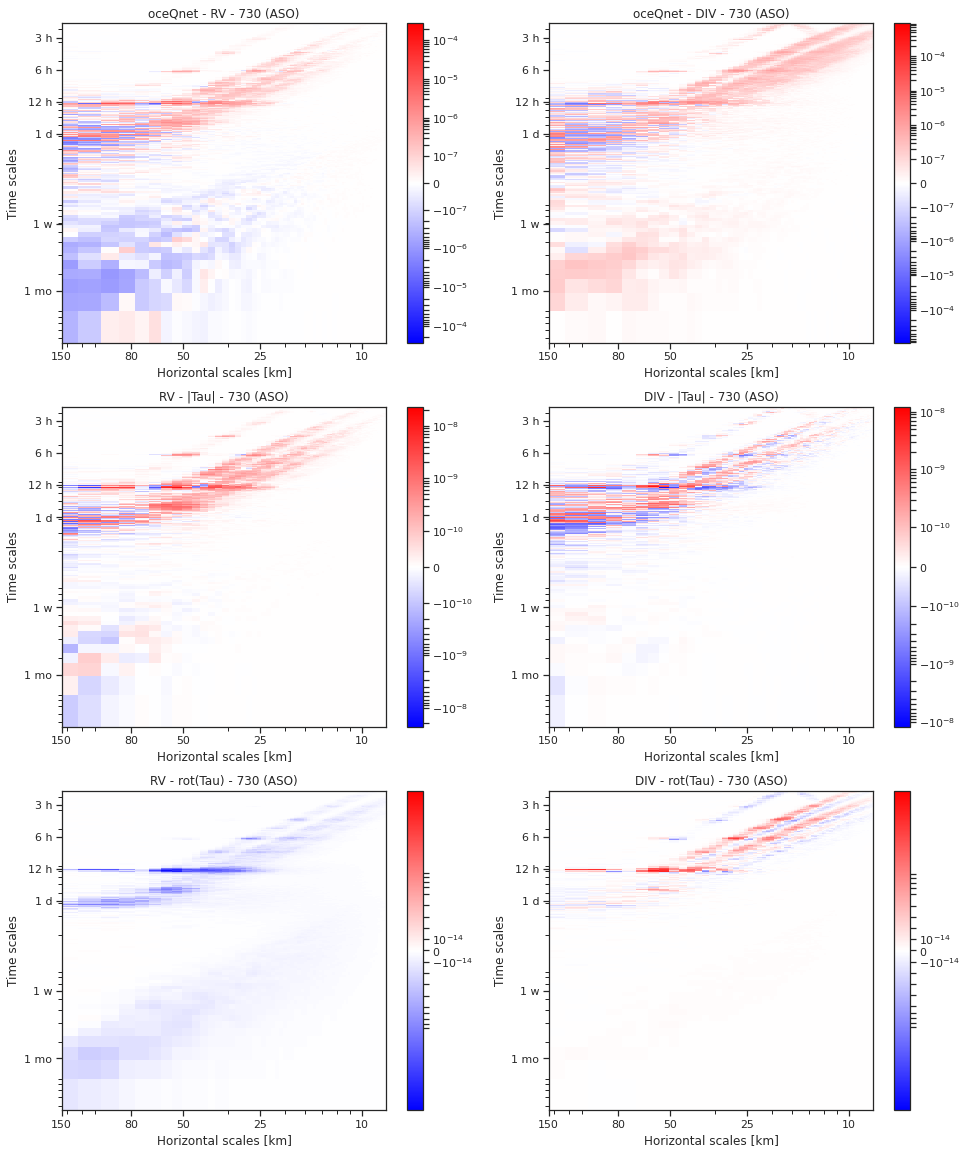

Plotting Canarias: 730 JFM
2020-11-20 14:47:46 INFO     Loading oceQnet: shape (k=0): (290, 289, 2184)
2020-11-20 14:49:42 INFO     Loading U: shape (k=0): (290, 289, 2184)
2020-11-20 14:51:58 INFO     Loading V: shape (k=0): (290, 289, 2184)
2020-11-20 14:54:14 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2184)
2020-11-20 14:56:16 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2184)
2020-11-20 14:58:08 INFO     Calculating tau_norm = |tau|
2020-11-20 14:58:09 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 14:58:15 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 14:58:19 INFO     Calculating uv_div = div(uv)
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184


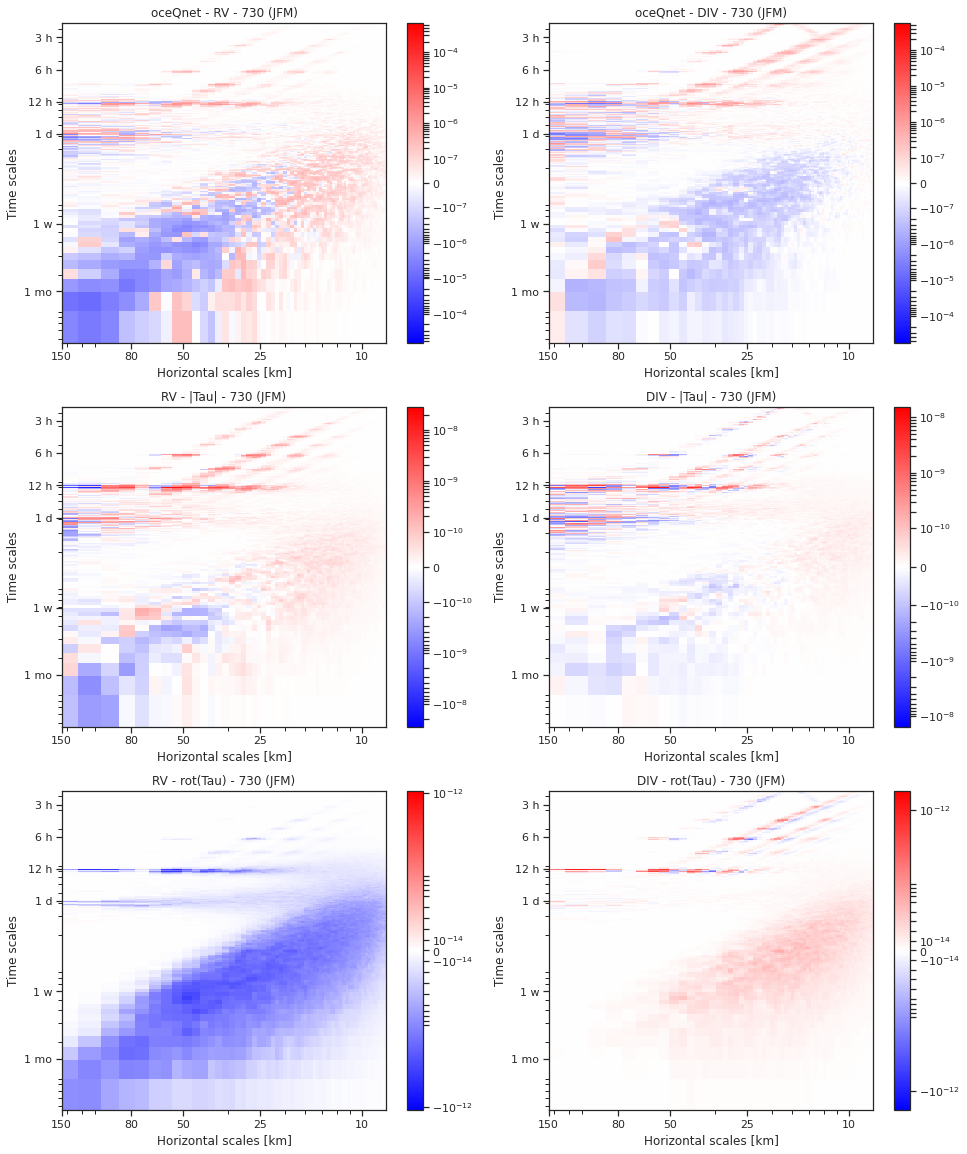

Plotting Canarias: 709 ASO
2020-11-20 15:01:26 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2020-11-20 15:04:12 INFO     Loading U: shape (k=0): (288, 289, 2208)
2020-11-20 15:06:55 INFO     Loading V: shape (k=0): (288, 289, 2208)
2020-11-20 15:09:31 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2020-11-20 15:12:12 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)
2020-11-20 15:14:54 INFO     Calculating tau_norm = |tau|
2020-11-20 15:14:56 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 15:15:01 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 15:15:05 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208


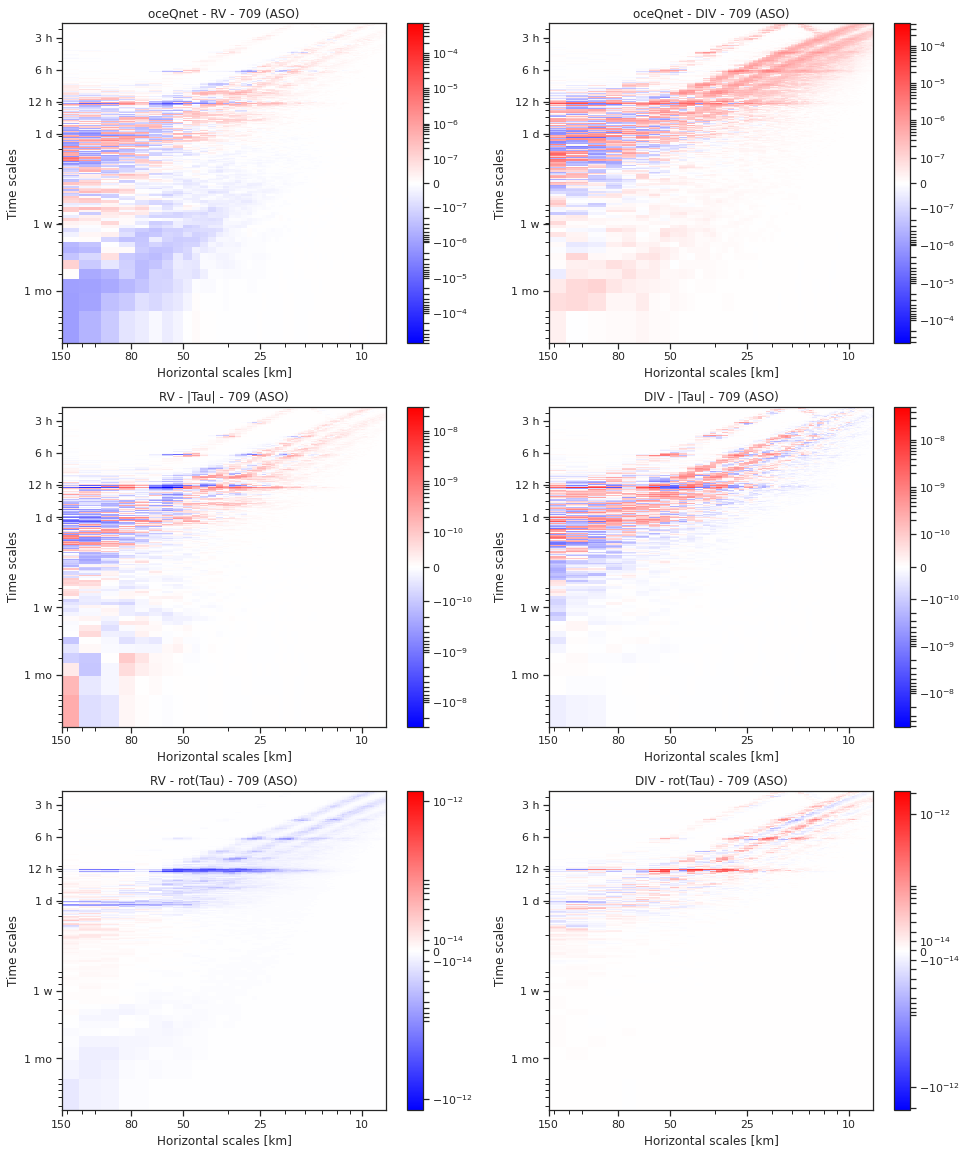

Plotting Canarias: 709 JFM
2020-11-20 15:18:04 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)
2020-11-20 15:20:06 INFO     Loading U: shape (k=0): (288, 289, 2184)
2020-11-20 15:22:22 INFO     Loading V: shape (k=0): (288, 289, 2184)
2020-11-20 15:24:40 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2020-11-20 15:27:04 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)
2020-11-20 15:29:09 INFO     Calculating tau_norm = |tau|
2020-11-20 15:29:11 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 15:29:17 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 15:29:21 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184


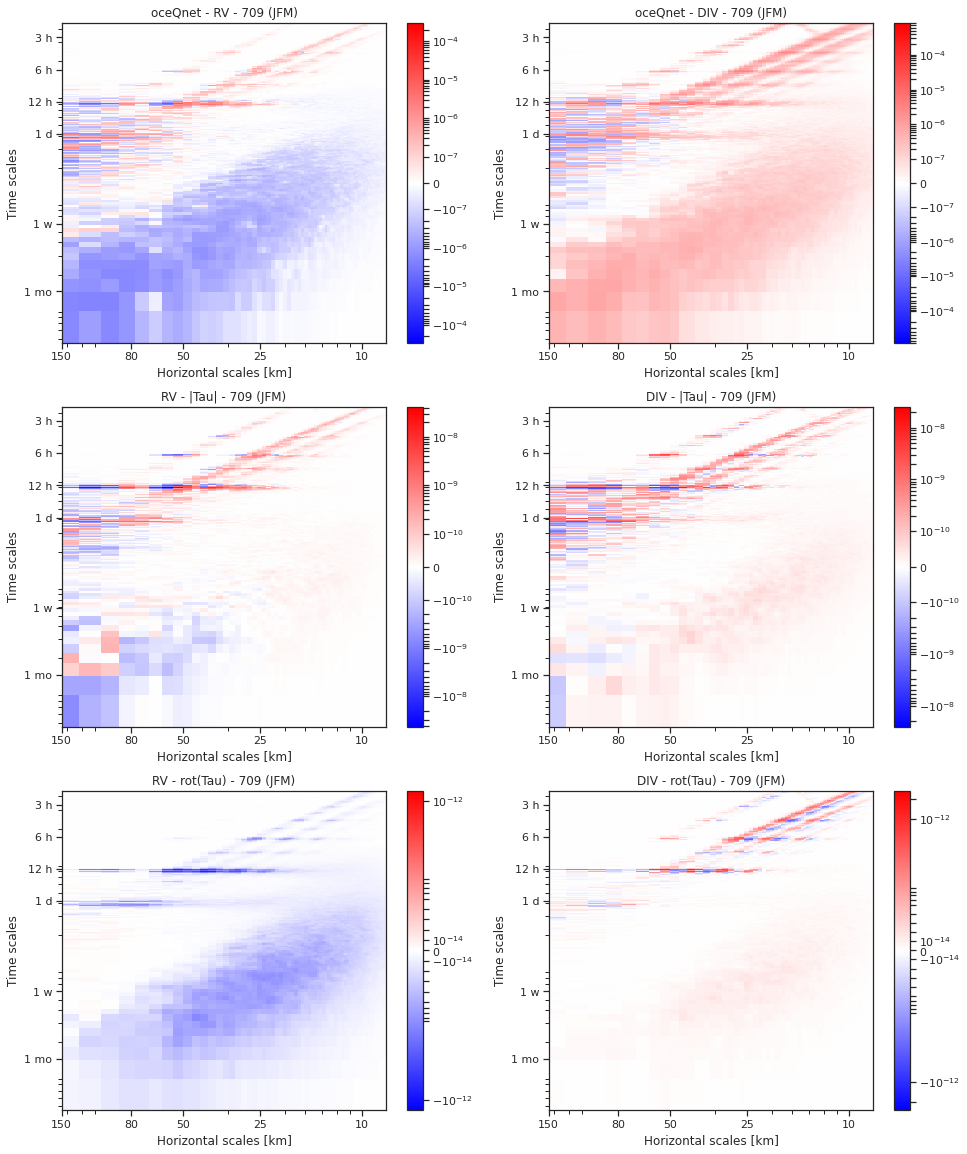

In [29]:
calc_cospectra("Canarias")

Plotting Peru: 596 ASO
2020-11-20 15:32:12 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2020-11-20 15:34:23 INFO     Loading U: shape (k=0): (288, 289, 2208)
2020-11-20 15:37:12 INFO     Loading V: shape (k=0): (288, 289, 2208)
2020-11-20 15:40:00 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2020-11-20 15:42:34 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)
2020-11-20 15:45:10 INFO     Calculating tau_norm = |tau|
2020-11-20 15:45:11 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 15:45:17 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 15:45:21 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208


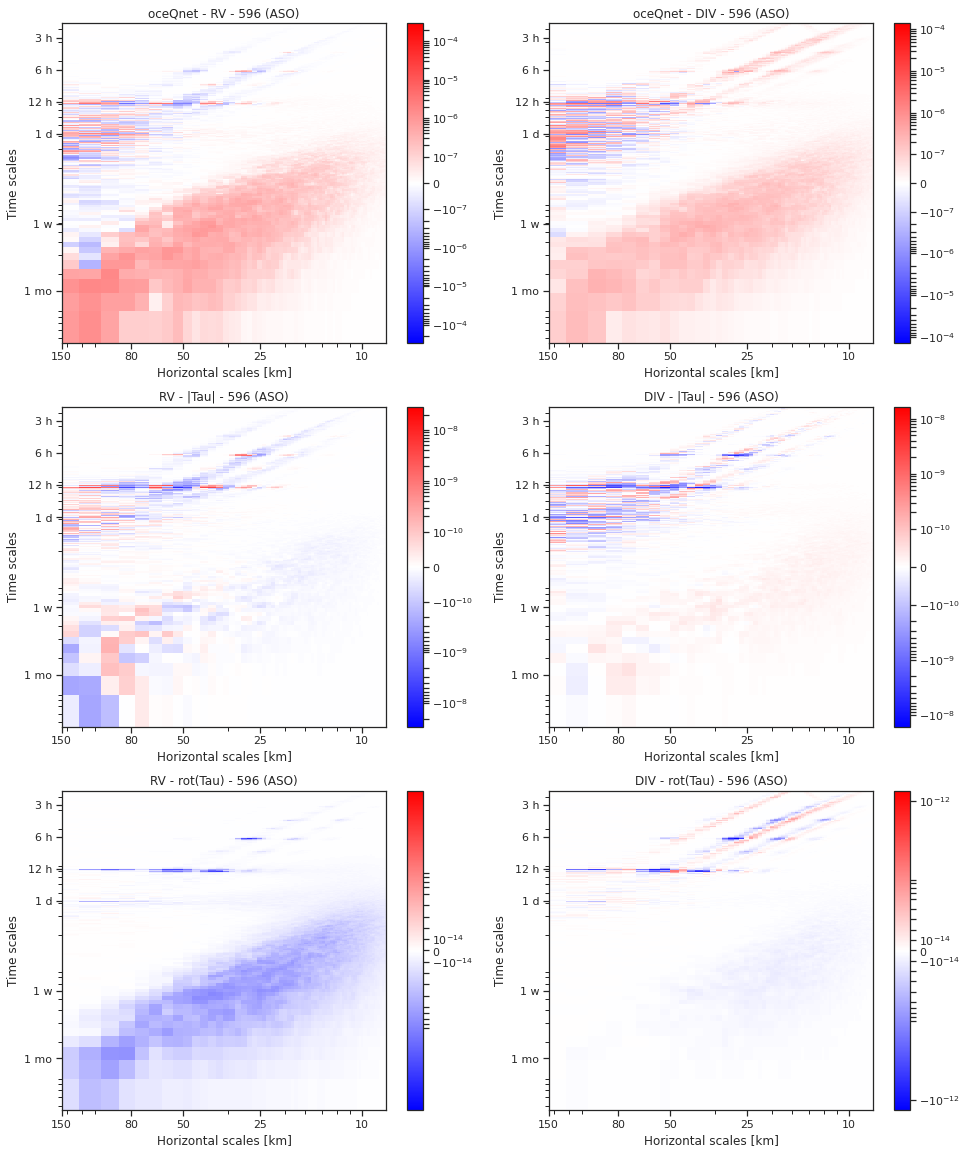

Plotting Peru: 596 JFM
2020-11-20 15:48:12 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)
2020-11-20 15:50:14 INFO     Loading U: shape (k=0): (288, 289, 2184)
2020-11-20 15:52:28 INFO     Loading V: shape (k=0): (288, 289, 2184)
2020-11-20 15:54:40 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2020-11-20 15:56:38 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)
2020-11-20 15:58:41 INFO     Calculating tau_norm = |tau|
2020-11-20 15:58:42 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 15:58:48 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 15:58:52 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184


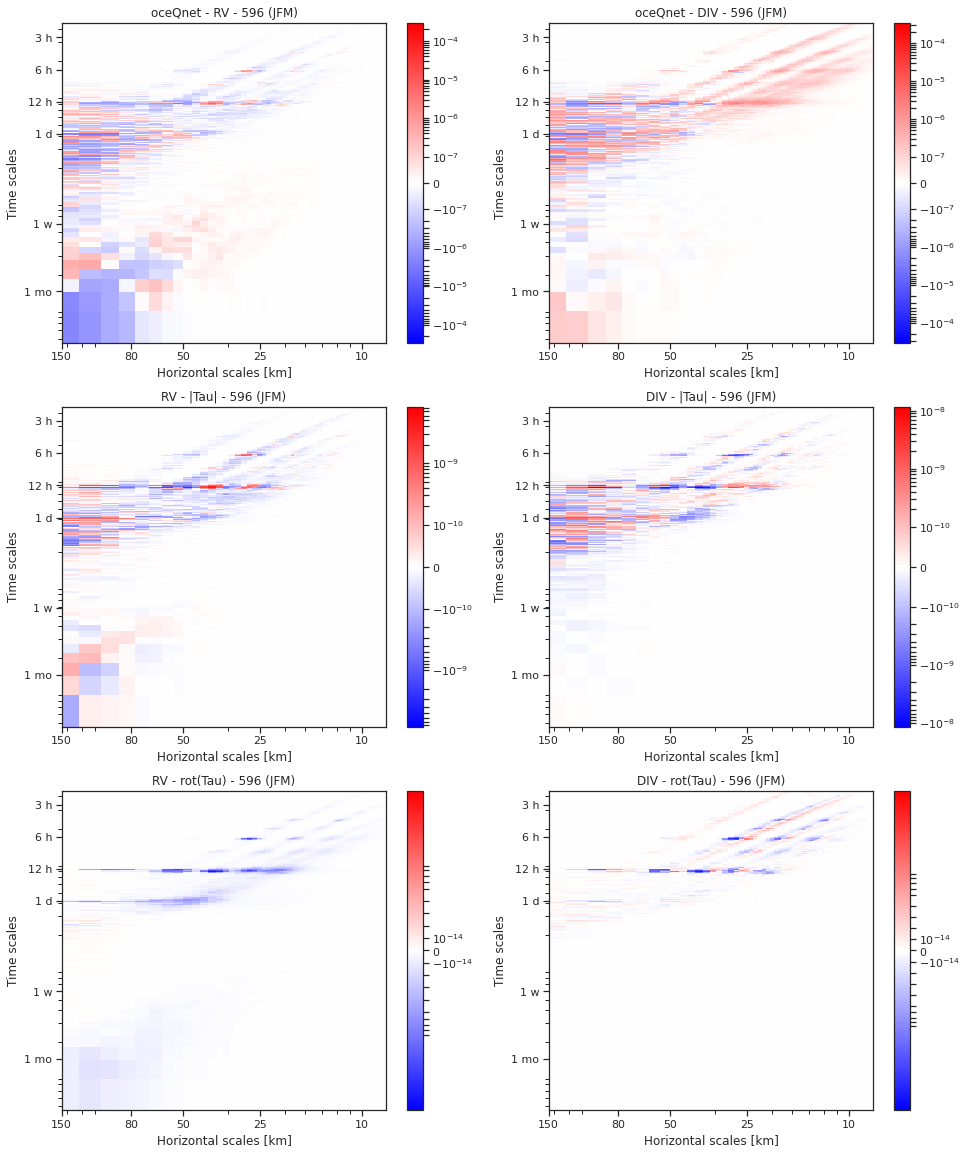

Plotting Peru: 572 ASO
2020-11-20 16:01:40 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)
2020-11-20 16:04:05 INFO     Loading U: shape (k=0): (290, 289, 2208)
2020-11-20 16:06:58 INFO     Loading V: shape (k=0): (290, 289, 2208)
2020-11-20 16:09:46 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2020-11-20 16:12:33 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)
2020-11-20 16:15:25 INFO     Calculating tau_norm = |tau|
2020-11-20 16:15:26 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 16:15:32 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 16:15:36 INFO     Calculating uv_div = div(uv)
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208


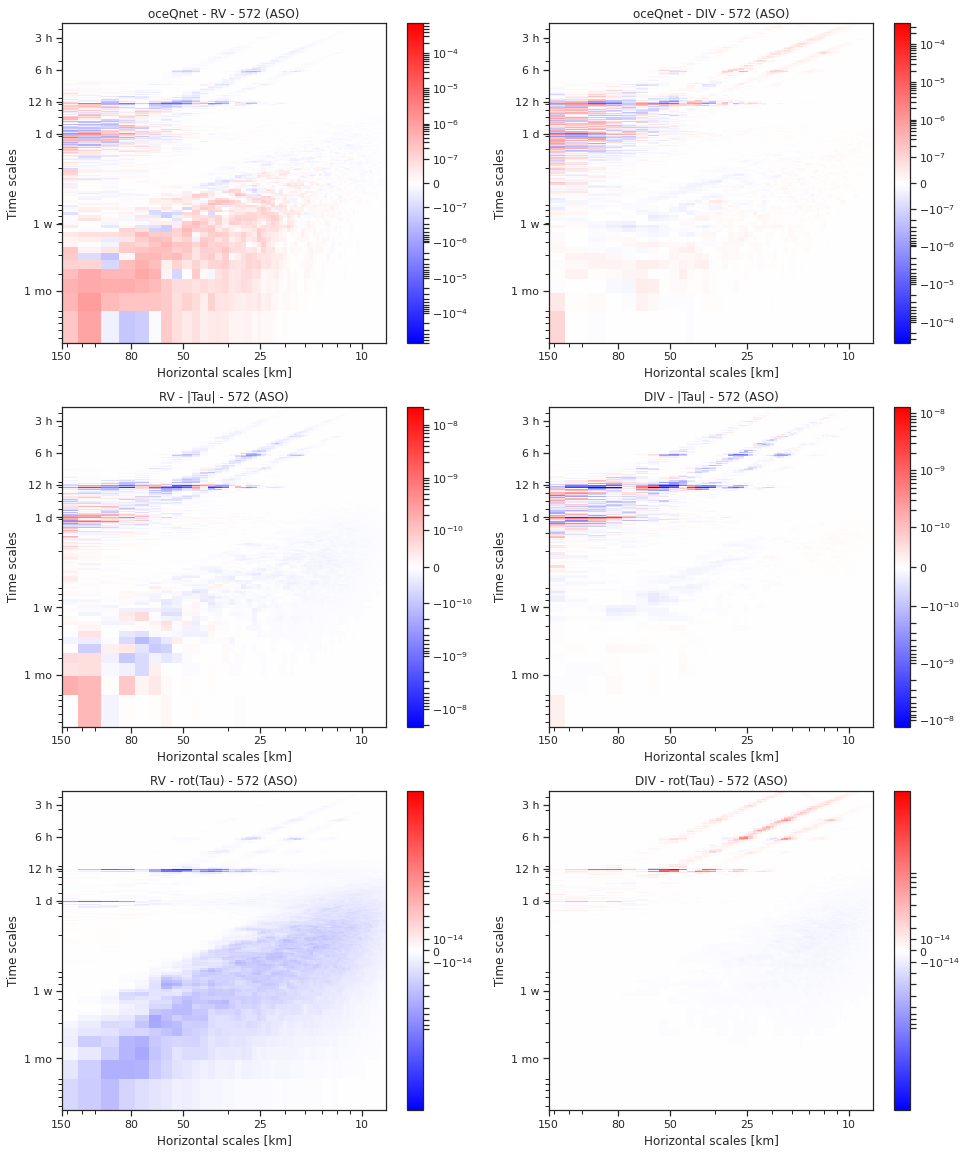

Plotting Peru: 572 JFM
2020-11-20 16:18:29 INFO     Loading oceQnet: shape (k=0): (290, 289, 2184)
2020-11-20 16:20:55 INFO     Loading U: shape (k=0): (290, 289, 2184)
2020-11-20 16:23:39 INFO     Loading V: shape (k=0): (290, 289, 2184)
2020-11-20 16:26:19 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2184)
2020-11-20 16:28:42 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2184)
2020-11-20 16:30:52 INFO     Calculating tau_norm = |tau|
2020-11-20 16:30:53 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 16:30:59 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 16:31:03 INFO     Calculating uv_div = div(uv)
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184


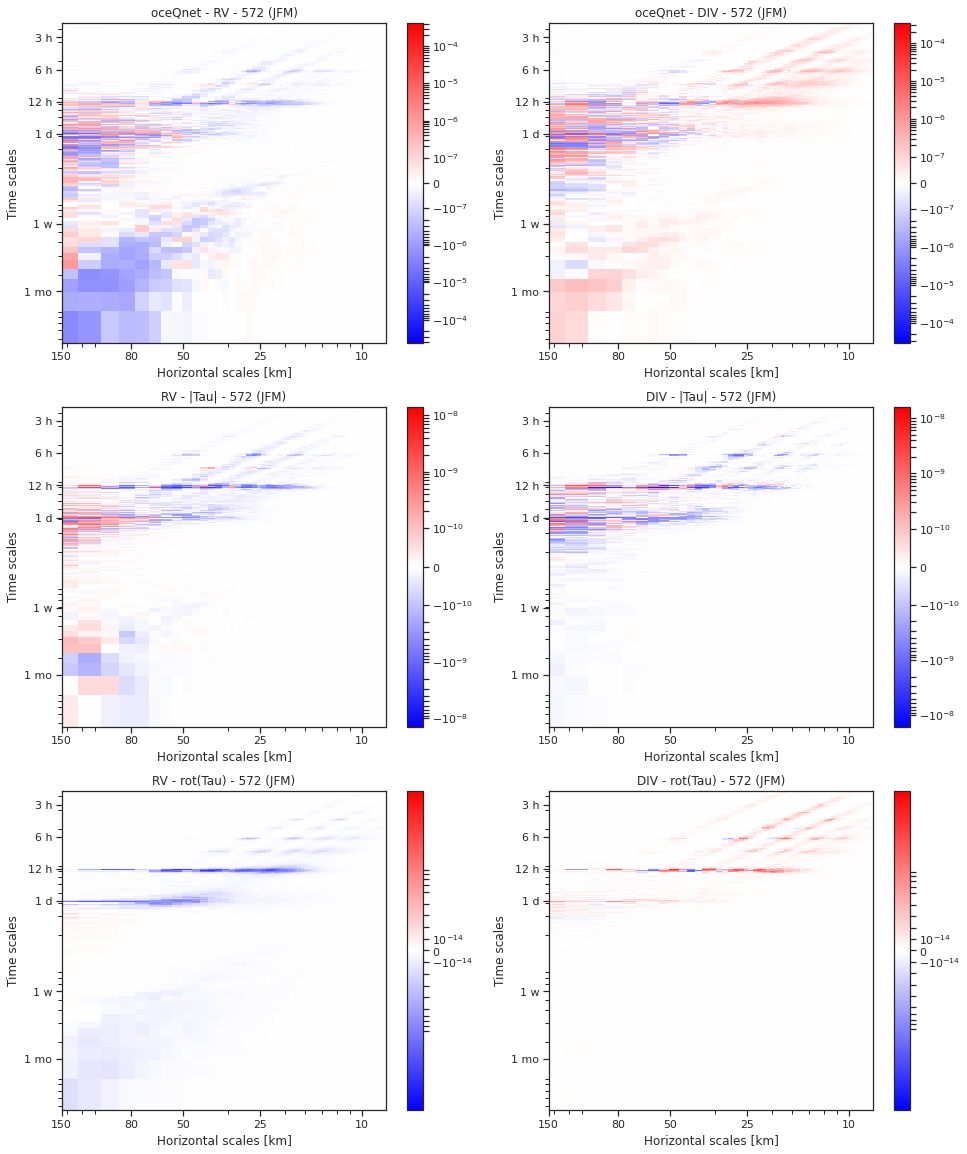

Plotting Peru: 450 ASO
2020-11-20 16:33:58 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)
2020-11-20 16:36:20 INFO     Loading U: shape (k=0): (290, 289, 2208)
2020-11-20 16:39:27 INFO     Loading V: shape (k=0): (290, 289, 2208)
2020-11-20 16:42:35 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2020-11-20 16:45:37 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)
2020-11-20 16:48:40 INFO     Calculating tau_norm = |tau|
2020-11-20 16:48:42 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 16:48:48 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 16:48:53 INFO     Calculating uv_div = div(uv)
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208


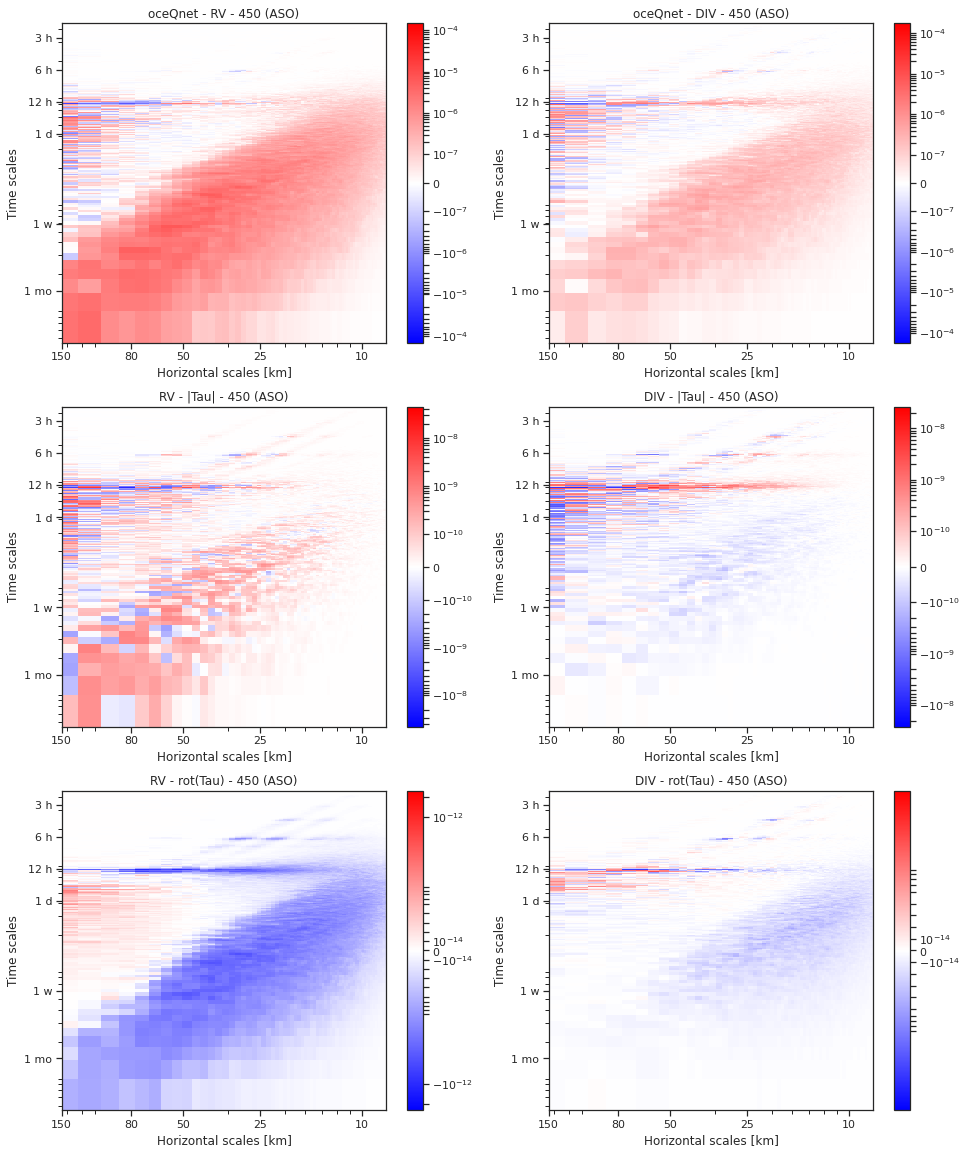

Plotting Peru: 450 JFM
2020-11-20 16:51:53 INFO     Loading oceQnet: shape (k=0): (290, 289, 2184)
2020-11-20 16:54:13 INFO     Loading U: shape (k=0): (290, 289, 2184)
2020-11-20 16:56:45 INFO     Loading V: shape (k=0): (290, 289, 2184)
2020-11-20 16:59:15 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2184)
2020-11-20 17:01:33 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2184)
2020-11-20 17:03:53 INFO     Calculating tau_norm = |tau|
2020-11-20 17:03:54 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 17:04:00 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 17:04:04 INFO     Calculating uv_div = div(uv)
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184


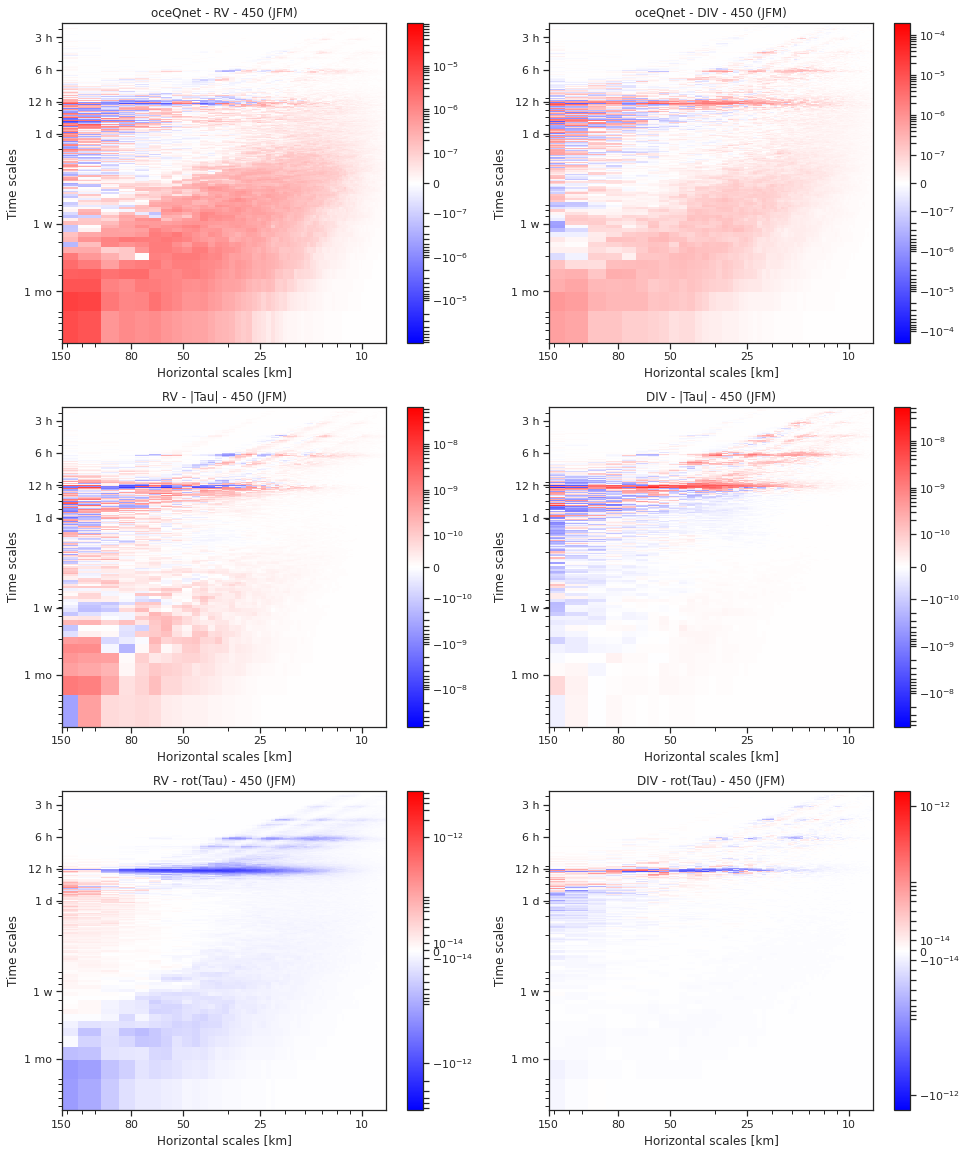

In [30]:
calc_cospectra("Peru")

Plotting Benguela: 602 ASO
2020-11-20 22:11:25 INFO     Loading oceQnet: shape (k=0): (290, 289, 2208)
2020-11-20 22:11:36 INFO     Loading U: shape (k=0): (290, 289, 2208)
2020-11-20 22:11:46 INFO     Loading V: shape (k=0): (290, 289, 2208)
2020-11-20 22:11:57 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2208)
2020-11-20 22:12:07 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2208)
2020-11-20 22:12:17 INFO     Calculating tau_norm = |tau|
2020-11-20 22:12:18 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 22:12:23 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 22:12:27 INFO     Calculating uv_div = div(uv)
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208
before fftn
290 289 2208


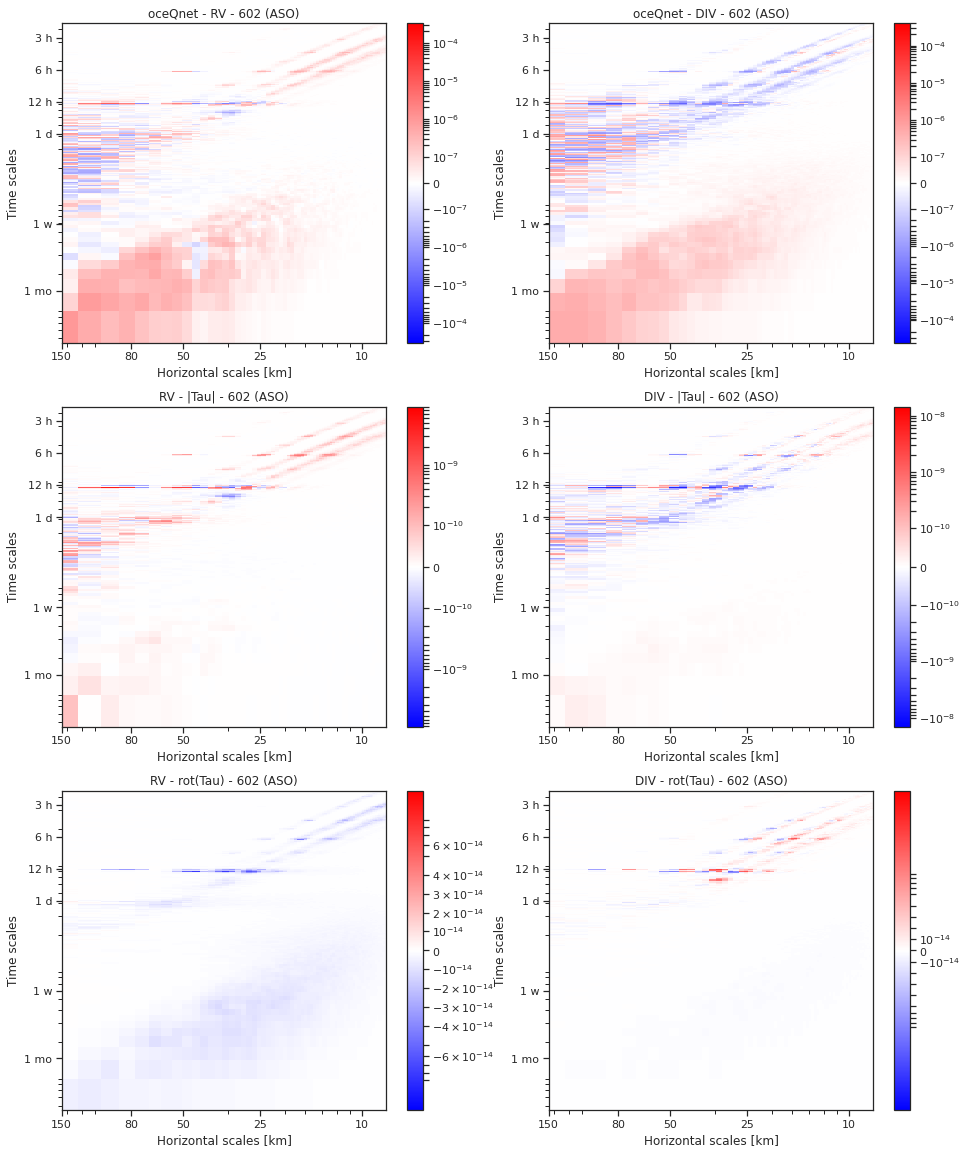

Plotting Benguela: 602 JFM
2020-11-20 22:15:00 INFO     Loading oceQnet: shape (k=0): (290, 289, 2184)
2020-11-20 22:15:10 INFO     Loading U: shape (k=0): (290, 289, 2184)
2020-11-20 22:15:18 INFO     Loading V: shape (k=0): (290, 289, 2184)
2020-11-20 22:15:27 INFO     Loading oceTAUX: shape (k=0): (290, 289, 2184)
2020-11-20 22:15:36 INFO     Loading oceTAUY: shape (k=0): (290, 289, 2184)
2020-11-20 22:15:45 INFO     Calculating tau_norm = |tau|
2020-11-20 22:15:47 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 22:15:51 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 22:15:56 INFO     Calculating uv_div = div(uv)
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184
before fftn
290 289 2184


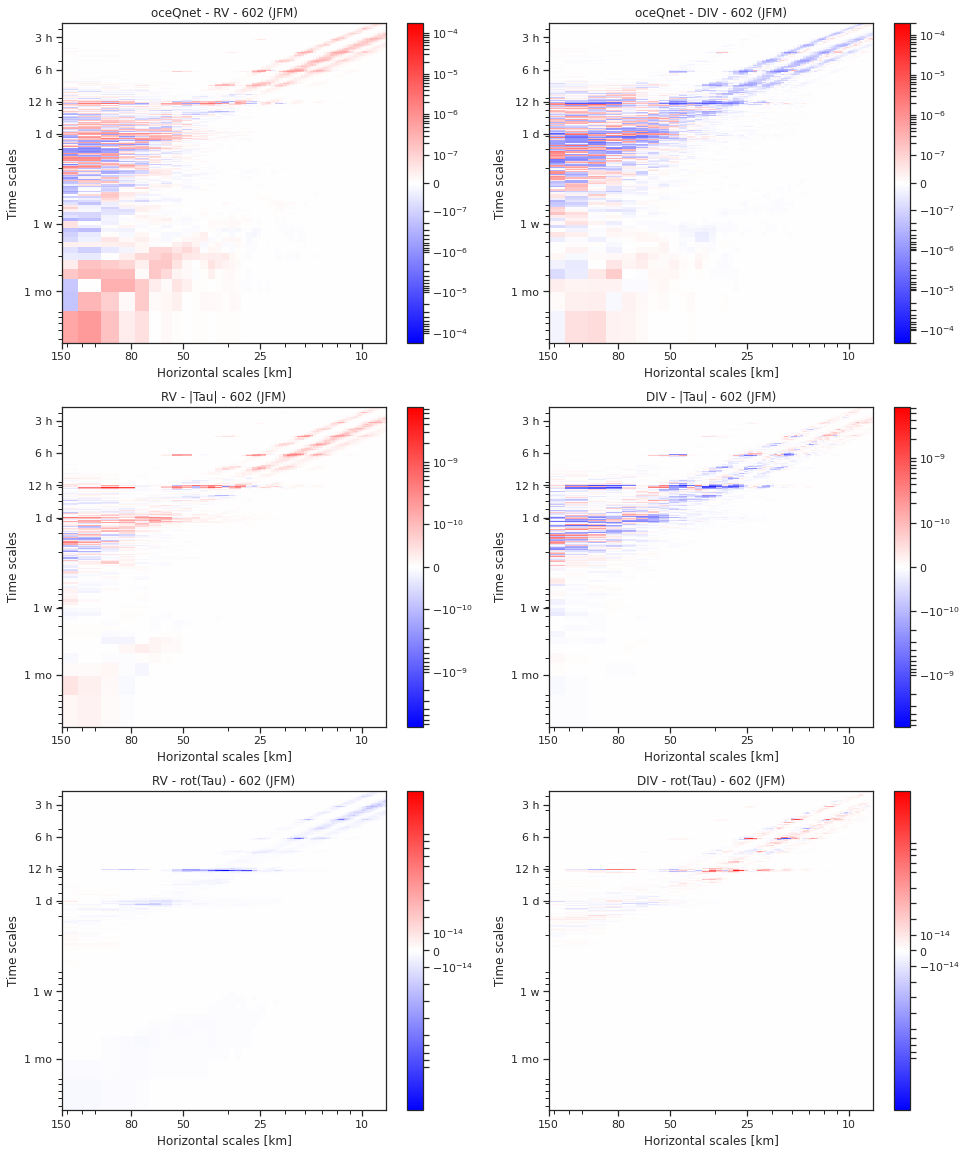

Plotting Benguela: 578 ASO
2020-11-20 22:18:28 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2020-11-20 22:18:38 INFO     Loading U: shape (k=0): (288, 289, 2208)
2020-11-20 22:18:48 INFO     Loading V: shape (k=0): (288, 289, 2208)
2020-11-20 22:18:57 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2020-11-20 22:19:07 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)
2020-11-20 22:19:17 INFO     Calculating tau_norm = |tau|
2020-11-20 22:19:18 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 22:19:23 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 22:19:27 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208


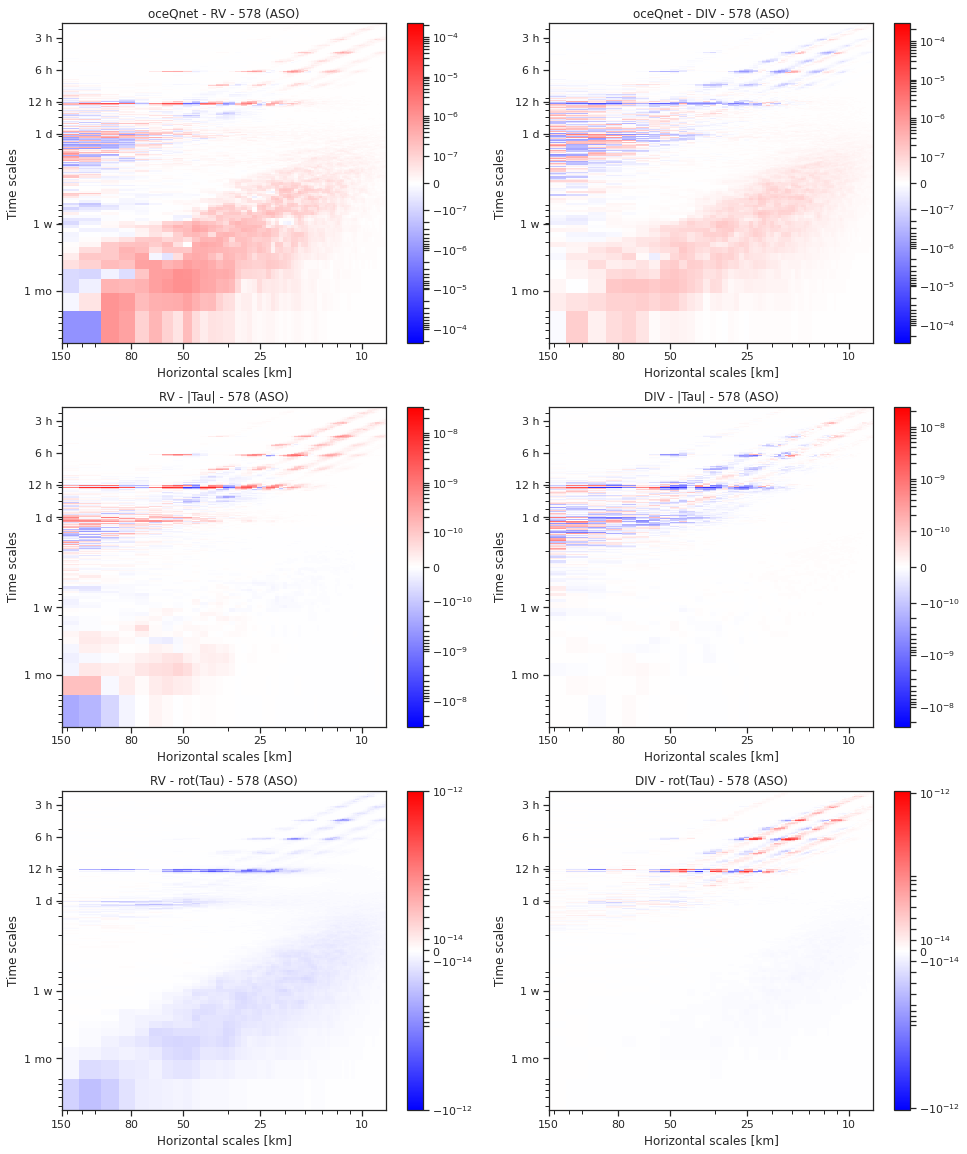

Plotting Benguela: 578 JFM
2020-11-20 22:21:54 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)
2020-11-20 22:22:04 INFO     Loading U: shape (k=0): (288, 289, 2184)
2020-11-20 22:22:13 INFO     Loading V: shape (k=0): (288, 289, 2184)
2020-11-20 22:22:22 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2020-11-20 22:22:31 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)
2020-11-20 22:22:40 INFO     Calculating tau_norm = |tau|
2020-11-20 22:22:42 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 22:22:46 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 22:22:50 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184


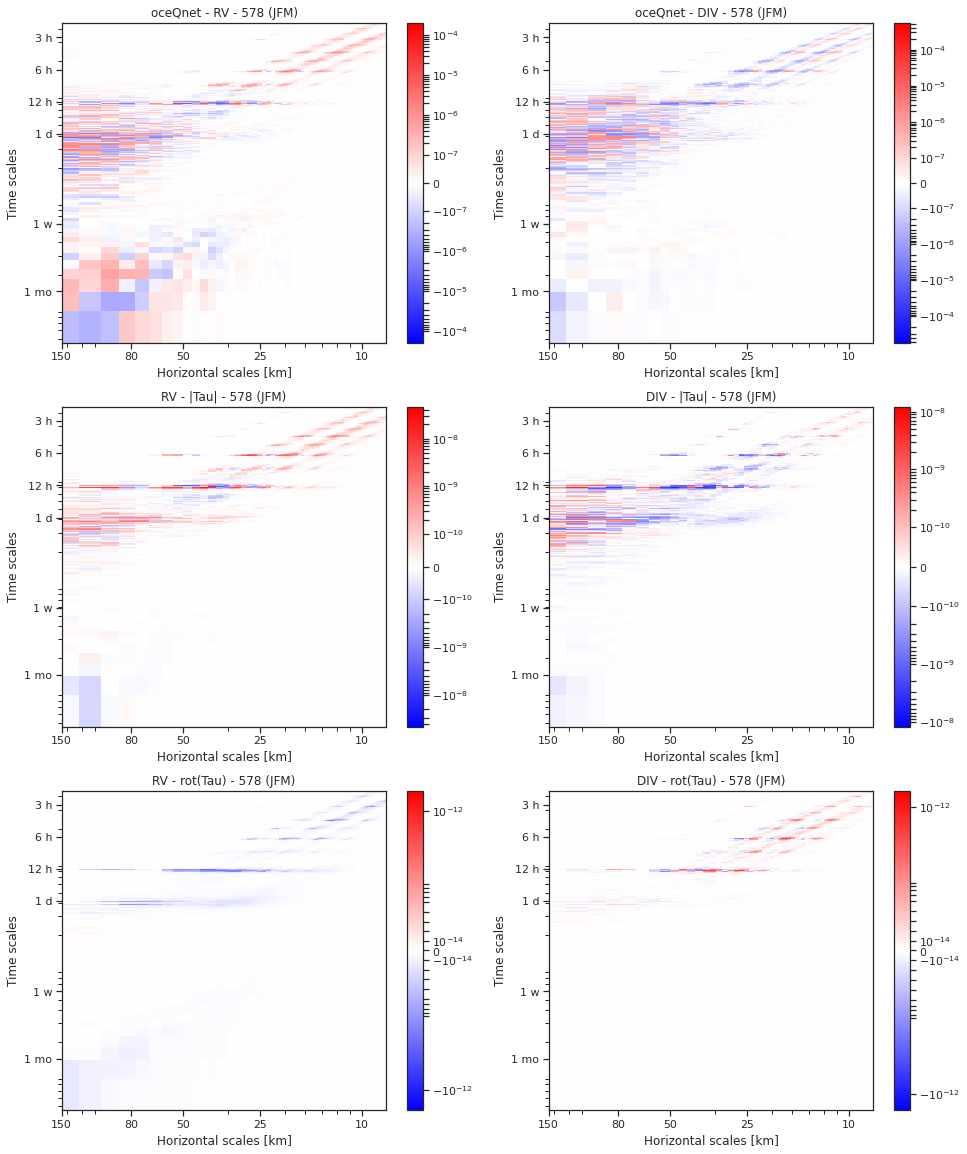

Plotting Benguela: 533 ASO
2020-11-20 22:25:16 INFO     Loading oceQnet: shape (k=0): (288, 289, 2208)
2020-11-20 22:25:26 INFO     Loading U: shape (k=0): (288, 289, 2208)
2020-11-20 22:25:36 INFO     Loading V: shape (k=0): (288, 289, 2208)
2020-11-20 22:25:46 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2208)
2020-11-20 22:25:55 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2208)
2020-11-20 22:26:05 INFO     Calculating tau_norm = |tau|
2020-11-20 22:26:07 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 22:26:11 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 22:26:16 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208
before fftn
288 289 2208


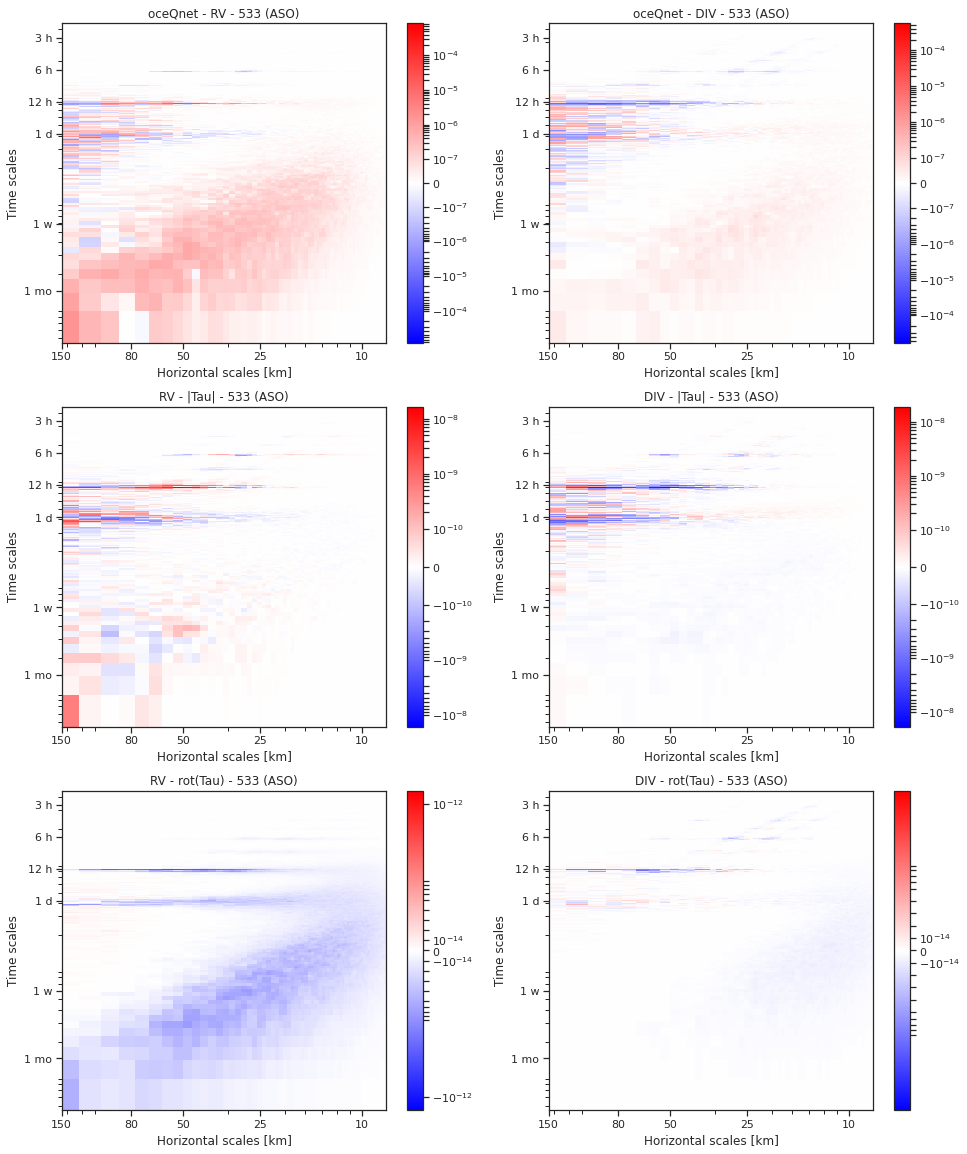

Plotting Benguela: 533 JFM
2020-11-20 22:28:42 INFO     Loading oceQnet: shape (k=0): (288, 289, 2184)
2020-11-20 22:28:52 INFO     Loading U: shape (k=0): (288, 289, 2184)
2020-11-20 22:29:01 INFO     Loading V: shape (k=0): (288, 289, 2184)
2020-11-20 22:29:10 INFO     Loading oceTAUX: shape (k=0): (288, 289, 2184)
2020-11-20 22:29:19 INFO     Loading oceTAUY: shape (k=0): (288, 289, 2184)
2020-11-20 22:29:28 INFO     Calculating tau_norm = |tau|
2020-11-20 22:29:30 INFO     Calculating tau_curl = curl_h(tau)
2020-11-20 22:29:34 INFO     Calculating uv_curl = curl_h(uv)
2020-11-20 22:29:38 INFO     Calculating uv_div = div(uv)
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184
before fftn
288 289 2184


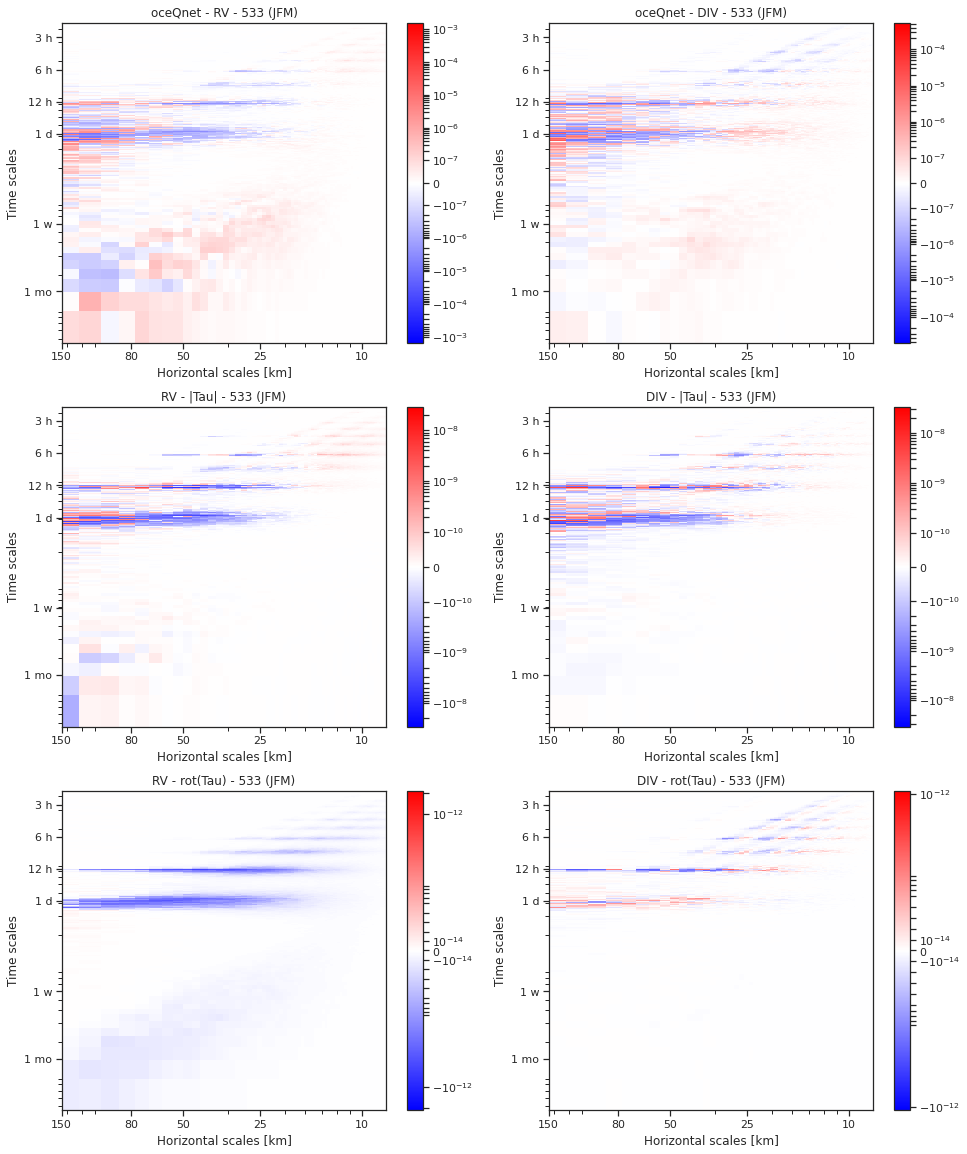

In [9]:
calc_cospectra("Benguela")